# Solar Plant Power Generation and Weather Data
https://www.kaggle.com/datasets/anikannal/solar-power-generation-data/data
##Problem Statement

**To analyze and predict the power generation of a solar plant and idenitify ways to improve efficency through the following steps:**
1. Data Collection and Analysis: This step involves gathering data from the solar plant, which could include solar irradiance, panel temperatures, weather conditions, and the actual power output. Analysis of this data helps in understanding the current performance of the plant.

2. Predictive Modelling: Using historical data, predictive models can be developed to forecast the power generation of the solar plant. This involves machine learning techniques and statistical models that take into account various factors like sunlight intensity, time of day, season, and weather conditions.

3. Efficiency Identification: This involves identifying factors that are currently limiting the efficiency of the solar plant. It could be due to suboptimal positioning of solar panels, inefficient solar panels, shading issues, or operational and maintenance challenges.

4. Performance Optimization: Based on the analysis and predictive models, strategies to optimize the performance of the solar plant can be developed. This could involve adjusting the angle of solar panels, upgrading equipment, implementing better cooling systems for panels, or optimizing the maintenance schedule.


# Dataset Description

This data has been gathered at two solar power plants in India over a 34 day period. It has two pairs of files - each pair has one power generation dataset and one sensor readings dataset. The power generation datasets are gathered at the inverter level - each inverter has multiple lines of solar panels attached to it. The sensor data is gathered at a plant level - single array of sensors optimally placed at the plant.






# Explanation of Analysis Methodology

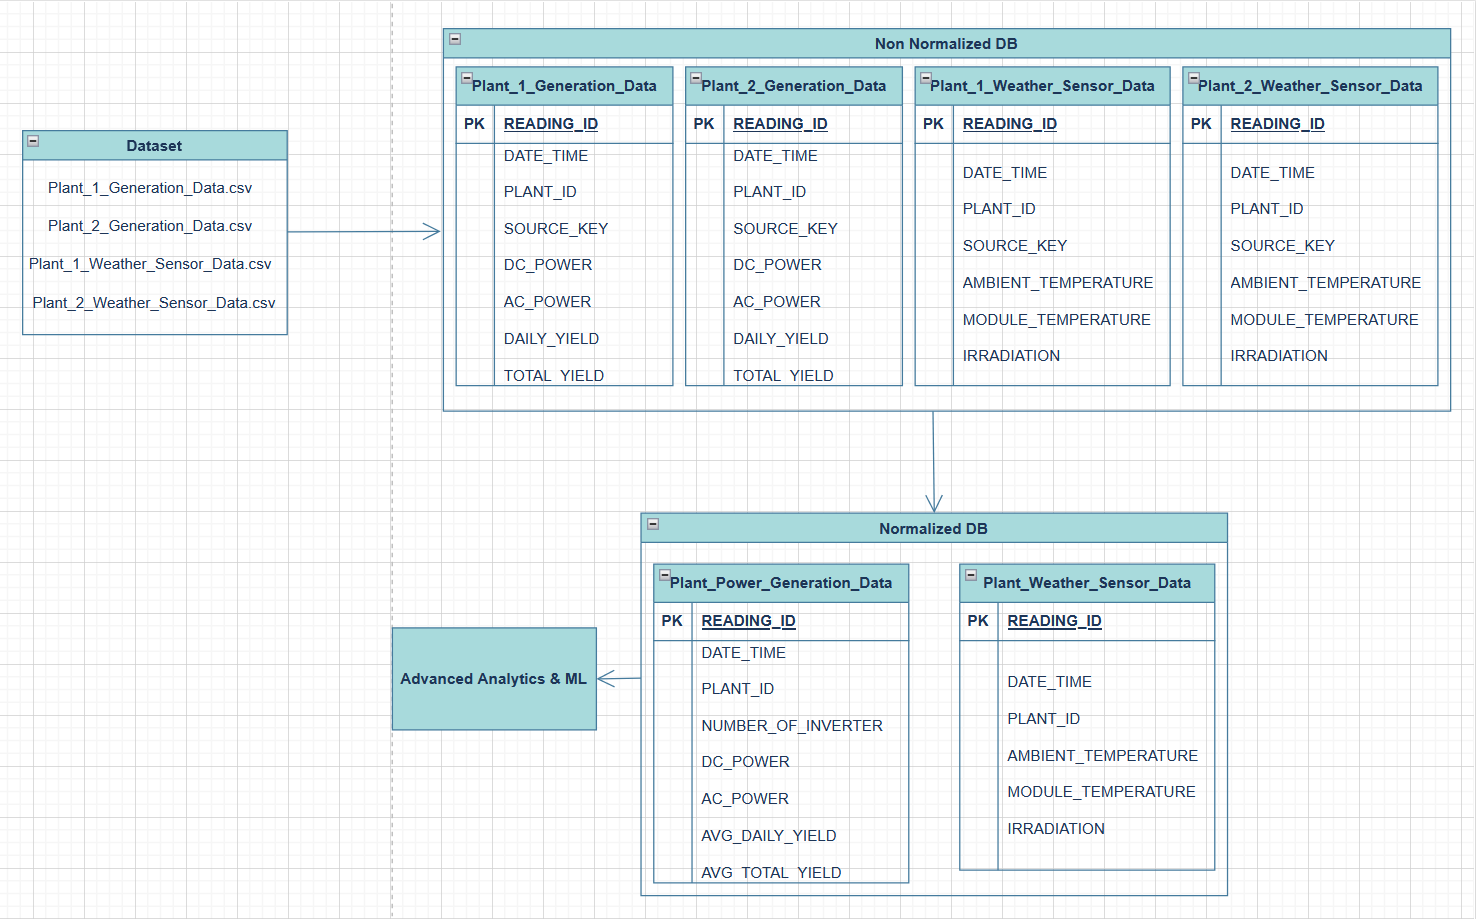


# 1. Parsing Component

In [ ]:
#Importing Essential Libraries

import pandas as pd
import math
import os
import sys
import numpy as np
import seaborn
import matplotlib.pyplot as plt
import sqlite3
import datetime

In [ ]:
# Mounting Google Drive
#from google.colab import drive
#drive.mount('/content/drive/')



In [ ]:
#Utility Functions

def create_connection(db_file, delete_db=False):
    import os
    if delete_db and os.path.exists(db_file):
        os.remove(db_file)

    conn = None
    try:
        conn = sqlite3.connect(db_file)
        conn.execute("PRAGMA foreign_keys = 1")
    except Exception as e:
        print(e)

    return conn


def create_table(conn, create_table_sql, drop_table_name=None):

    if drop_table_name: # You can optionally pass drop_table_name to drop the table.
        try:
            c = conn.cursor()
            c.execute("""DROP TABLE IF EXISTS %s""" % (drop_table_name))
        except Exception as e:
            print(e)

    try:
        c = conn.cursor()
        c.execute(create_table_sql)

    except Exception as e:
        print(e)

def execute_sql_statement(sql_statement, conn):
    cur = conn.cursor()
    cur.execute(sql_statement)

    rows = cur.fetchall()

    return rows





In [ ]:
# Reading file that is manually uploaded rather than drive
data_path = '/content/'

os.listdir(data_path)

['.config',
 'Plant_2_Generation_Data.csv',
 'unnormalized.db',
 'Plant_1_Generation_Data.csv',
 'Plant_2_Weather_Sensor_Data.csv',
 'Plant_1_Weather_Sensor_Data.csv',
 'sample_data']

In [ ]:
pd.read_csv(os.path.join(data_path,'Plant_1_Generation_Data.csv')).head()

DATE_TIME  PLANT_ID       SOURCE_KEY  DC_POWER  AC_POWER  \
0  15-05-2020 00:00   4135001  1BY6WEcLGh8j5v7       0.0       0.0   
1  15-05-2020 00:00   4135001  1IF53ai7Xc0U56Y       0.0       0.0   
2  15-05-2020 00:00   4135001  3PZuoBAID5Wc2HD       0.0       0.0   
3  15-05-2020 00:00   4135001  7JYdWkrLSPkdwr4       0.0       0.0   
4  15-05-2020 00:00   4135001  McdE0feGgRqW7Ca       0.0       0.0   

   DAILY_YIELD  TOTAL_YIELD  
0          0.0    6259559.0  
1          0.0    6183645.0  
2          0.0    6987759.0  
3          0.0    7602960.0  
4          0.0    7158964.0

In [ ]:
pd.read_csv(os.path.join(data_path,'Plant_1_Weather_Sensor_Data.csv')).head()

DATE_TIME  PLANT_ID       SOURCE_KEY  AMBIENT_TEMPERATURE  \
0  2020-05-15 00:00:00   4135001  HmiyD2TTLFNqkNe            25.184316   
1  2020-05-15 00:15:00   4135001  HmiyD2TTLFNqkNe            25.084589   
2  2020-05-15 00:30:00   4135001  HmiyD2TTLFNqkNe            24.935753   
3  2020-05-15 00:45:00   4135001  HmiyD2TTLFNqkNe            24.846130   
4  2020-05-15 01:00:00   4135001  HmiyD2TTLFNqkNe            24.621525   

   MODULE_TEMPERATURE  IRRADIATION  
0           22.857507          0.0  
1           22.761668          0.0  
2           22.592306          0.0  
3           22.360852          0.0  
4           22.165423          0.0

# Reading Data to Non-normalized SQL Database


In [ ]:
# Parsing Plant_1_Generation_Data.csv

un_normal_db_name = os.path.join(data_path,'unnormalized.db')
unnormal_conn = create_connection(un_normal_db_name, delete_db=True)


plant_1_data_path = os.path.join(data_path,'Plant_1_Generation_Data.csv')

sql_statement = """
        CREATE TABLE Plant_1_Generation_Data (
        READING_ID INTEGER NOT NULL PRIMARY KEY,
        DATE_TIME TEXT NOT NULL,
        PLANT_ID INTEGER NOT NULL,
        SOURCE_KEY TEXT NOT NULL,
        DC_POWER REAL NOT NULL,
        AC_POWER REAL NOT NULL,
        DAILY_YIELD REAL NOT NULL,
        TOTAL_YIELD REAL NOT NULL)"""

create_table(unnormal_conn,sql_statement,drop_table_name='Plant_1_Generation_Data')

with open(plant_1_data_path,'r') as f:
  lines = f.readlines()

tuple_list = []
id = 1
for line in lines[1:]:
  line_split = line.split(',')
  line_split = [row.strip() for row in line_split]
  temp_tuple = (id,line_split[0],int(line_split[1]),
                line_split[2],float(line_split[3]),
                float(line_split[4]),float(line_split[5]),
                float(line_split[6]))
  tuple_list.append(temp_tuple)
  id +=1

curr =  unnormal_conn.cursor()
curr.executemany("INSERT INTO Plant_1_Generation_Data VALUES (?,?,?,?,?,?,?,?)",tuple_list)
curr.close()
unnormal_conn.commit()



print(execute_sql_statement('SELECT * FROM Plant_1_Generation_Data LIMIT 5',unnormal_conn))
print(execute_sql_statement('SELECT COUNT(*) FROM Plant_1_Generation_Data',unnormal_conn))

unnormal_conn.close()





[(1, '15-05-2020 00:00', 4135001, '1BY6WEcLGh8j5v7', 0.0, 0.0, 0.0, 6259559.0), (2, '15-05-2020 00:00', 4135001, '1IF53ai7Xc0U56Y', 0.0, 0.0, 0.0, 6183645.0), (3, '15-05-2020 00:00', 4135001, '3PZuoBAID5Wc2HD', 0.0, 0.0, 0.0, 6987759.0), (4, '15-05-2020 00:00', 4135001, '7JYdWkrLSPkdwr4', 0.0, 0.0, 0.0, 7602960.0), (5, '15-05-2020 00:00', 4135001, 'McdE0feGgRqW7Ca', 0.0, 0.0, 0.0, 7158964.0)]
[(68778,)]


In [ ]:
# Parsing Plant_2_Generation_Data.csv

un_normal_db_name = os.path.join(data_path,'unnormalized.db')
unnormal_conn = create_connection(un_normal_db_name, delete_db=False)


plant_2_data_path = os.path.join(data_path,'Plant_2_Generation_Data.csv')

sql_statement = """
        CREATE TABLE Plant_2_Generation_Data (
        READING_ID INTEGER NOT NULL PRIMARY KEY,
        DATE_TIME TEXT NOT NULL,
        PLANT_ID INTEGER NOT NULL,
        SOURCE_KEY TEXT NOT NULL,
        DC_POWER REAL NOT NULL,
        AC_POWER REAL NOT NULL,
        DAILY_YIELD REAL NOT NULL,
        TOTAL_YIELD REAL NOT NULL)"""

create_table(unnormal_conn,sql_statement,drop_table_name='Plant_2_Generation_Data')

with open(plant_2_data_path,'r') as f:
  lines = f.readlines()

tuple_list = []
id = 1
for line in lines[1:]:
  line_split = line.split(',')
  line_split = [row.strip() for row in line_split]
  temp_tuple = (id,line_split[0],int(line_split[1]),
                line_split[2],float(line_split[3]),
                float(line_split[4]),float(line_split[5]),
                float(line_split[6]))
  tuple_list.append(temp_tuple)
  id +=1

curr =  unnormal_conn.cursor()
curr.executemany("INSERT INTO Plant_2_Generation_Data VALUES (?,?,?,?,?,?,?,?)",tuple_list)
curr.close()
unnormal_conn.commit()



print(execute_sql_statement('SELECT * FROM Plant_2_Generation_Data LIMIT 5',unnormal_conn))
print(execute_sql_statement('SELECT COUNT(*) FROM Plant_2_Generation_Data',unnormal_conn))

unnormal_conn.close()

[(1, '2020-05-15 00:00:00', 4136001, '4UPUqMRk7TRMgml', 0.0, 0.0, 9425.0, 2429011.0), (2, '2020-05-15 00:00:00', 4136001, '81aHJ1q11NBPMrL', 0.0, 0.0, 0.0, 1215278736.0), (3, '2020-05-15 00:00:00', 4136001, '9kRcWv60rDACzjR', 0.0, 0.0, 3075.3333333333344, 2247719577.0), (4, '2020-05-15 00:00:00', 4136001, 'Et9kgGMDl729KT4', 0.0, 0.0, 269.9333333333333, 1704250.0), (5, '2020-05-15 00:00:00', 4136001, 'IQ2d7wF4YD8zU1Q', 0.0, 0.0, 3177.0, 19941526.0)]
[(67698,)]


In [ ]:
# Parsing Plant_1_Weather_Sensor_Data.csv

un_normal_db_name = os.path.join(data_path,'unnormalized.db')
unnormal_conn = create_connection(un_normal_db_name, delete_db=False)


plant_1_sensor_data_path = os.path.join(data_path,'Plant_1_Weather_Sensor_Data.csv')

sql_statement = """
        CREATE TABLE Plant_1_Weather_Sensor_Data (
        READING_ID INTEGER NOT NULL PRIMARY KEY,
        DATE_TIME TEXT NOT NULL,
        PLANT_ID INTEGER NOT NULL,
        SOURCE_KEY TEXT NOT NULL,
        AMBIENT_TEMPERATURE REAL NOT NULL,
        MODULE_TEMPERATURE REAL NOT NULL,
        IRRADIATION REAL NOT NULL)"""

create_table(unnormal_conn,sql_statement,drop_table_name='Plant_1_Weather_Sensor_Data')

with open(plant_1_sensor_data_path,'r') as f:
  lines = f.readlines()

tuple_list = []
id = 1
for line in lines[1:]:
  line_split = line.split(',')
  line_split = [row.strip() for row in line_split]
  temp_tuple = (id,line_split[0],int(line_split[1]),
                line_split[2],float(line_split[3]),
                float(line_split[4]),float(line_split[5]))
  tuple_list.append(temp_tuple)
  id +=1

curr =  unnormal_conn.cursor()
curr.executemany("INSERT INTO Plant_1_Weather_Sensor_Data VALUES (?,?,?,?,?,?,?)",tuple_list)
curr.close()
unnormal_conn.commit()



print(execute_sql_statement('SELECT * FROM Plant_1_Weather_Sensor_Data LIMIT 5',unnormal_conn))
print(execute_sql_statement('SELECT COUNT(*) FROM Plant_1_Weather_Sensor_Data',unnormal_conn))

unnormal_conn.close()

[(1, '2020-05-15 00:00:00', 4135001, 'HmiyD2TTLFNqkNe', 25.184316133333333, 22.8575074, 0.0), (2, '2020-05-15 00:15:00', 4135001, 'HmiyD2TTLFNqkNe', 25.08458866666667, 22.761667866666663, 0.0), (3, '2020-05-15 00:30:00', 4135001, 'HmiyD2TTLFNqkNe', 24.935752600000004, 22.592305533333334, 0.0), (4, '2020-05-15 00:45:00', 4135001, 'HmiyD2TTLFNqkNe', 24.8461304, 22.360852133333335, 0.0), (5, '2020-05-15 01:00:00', 4135001, 'HmiyD2TTLFNqkNe', 24.621525357142858, 22.165422642857145, 0.0)]
[(3182,)]


In [ ]:
# Parsing Plant_2_Weather_Sensor_Data.csv

un_normal_db_name = os.path.join(data_path,'unnormalized.db')
unnormal_conn = create_connection(un_normal_db_name, delete_db=False)


plant_2_sensor_data_path = os.path.join(data_path,'Plant_2_Weather_Sensor_Data.csv')

sql_statement = """
        CREATE TABLE Plant_2_Weather_Sensor_Data (
        READING_ID INTEGER NOT NULL PRIMARY KEY,
        DATE_TIME TEXT NOT NULL,
        PLANT_ID INTEGER NOT NULL,
        SOURCE_KEY TEXT NOT NULL,
        AMBIENT_TEMPERATURE REAL NOT NULL,
        MODULE_TEMPERATURE REAL NOT NULL,
        IRRADIATION REAL NOT NULL)"""

create_table(unnormal_conn,sql_statement,drop_table_name='Plant_2_Weather_Sensor_Data')

with open(plant_2_sensor_data_path,'r') as f:
  lines = f.readlines()

tuple_list = []
id = 1
for line in lines[1:]:
  line_split = line.split(',')
  line_split = [row.strip() for row in line_split]
  temp_tuple = (id,line_split[0],int(line_split[1]),
                line_split[2],float(line_split[3]),
                float(line_split[4]),float(line_split[5]))
  tuple_list.append(temp_tuple)
  id +=1

curr =  unnormal_conn.cursor()
curr.executemany("INSERT INTO Plant_2_Weather_Sensor_Data VALUES (?,?,?,?,?,?,?)",tuple_list)
curr.close()
unnormal_conn.commit()



print(execute_sql_statement('SELECT * FROM Plant_2_Weather_Sensor_Data LIMIT 5',unnormal_conn))
print(execute_sql_statement('SELECT COUNT(*) FROM Plant_2_Weather_Sensor_Data',unnormal_conn))

unnormal_conn.close()

[(1, '2020-05-15 00:00:00', 4136001, 'iq8k7ZNt4Mwm3w0', 27.004763700000005, 25.0607889, 0.0), (2, '2020-05-15 00:15:00', 4136001, 'iq8k7ZNt4Mwm3w0', 26.880811433333328, 24.42186883333333, 0.0), (3, '2020-05-15 00:30:00', 4136001, 'iq8k7ZNt4Mwm3w0', 26.682055344827592, 24.427290310344823, 0.0), (4, '2020-05-15 00:45:00', 4136001, 'iq8k7ZNt4Mwm3w0', 26.500588900000004, 24.420677599999998, 0.0), (5, '2020-05-15 01:00:00', 4136001, 'iq8k7ZNt4Mwm3w0', 26.596148, 25.088210413793107, 0.0)]
[(3259,)]


# Normalizing Plant 1 and Plant 2 Power Generation and Weather Sensor Data
1. Concatenating Power Generation Data into a Single Normalised Table. Aggregating for all inverters and creating 'Number_of_Inverter' for each time stamp
2. Concatenating Weather Sensor Data into a Single Normalised Table


In [ ]:
# Normalizing Plant_1_Generation_Data and Plant_2_Generation_Data

un_normal_db_name = os.path.join(data_path,'unnormalized.db')
unnormal_conn = create_connection(un_normal_db_name, delete_db=False)

normal_db_name = os.path.join(data_path,'normalized.db')
normal_conn = create_connection(normal_db_name, delete_db=True)



sql_statement = """
        CREATE TABLE Plant_Power_Generation_Data (
        READING_ID INTEGER NOT NULL PRIMARY KEY,
        DATE_TIME TEXT NOT NULL,
        PLANT_ID INTEGER NOT NULL,
        NUMBER_OF_INVERTER INTEGER NOT NULL,
        DC_POWER REAL NOT NULL,
        AC_POWER REAL NOT NULL,
        AVG_DAILY_YIELD REAL NOT NULL,
        AVG_TOTAL_YIELD REAL NOT NULL)"""

create_table(normal_conn,sql_statement,drop_table_name='Plant_Power_Generation_Data')


sql_statement = """
        SELECT DATE_TIME,PLANT_ID,COUNT(READING_ID) AS NUMBER_OF_INVERTER,
        SUM(DC_POWER) AS DC_POWER,SUM(AC_POWER) AS AC_POWER,
        AVG(DAILY_YIELD) AS AVG_DAILY_YIELD,AVG(TOTAL_YIELD) AS AVG_TOTAL_YIELD
          FROM Plant_1_Generation_Data
        GROUP BY DATE_TIME"""

plant_1_rows = execute_sql_statement(sql_statement,unnormal_conn)

sql_statement = """
        SELECT DATE_TIME,PLANT_ID,COUNT(READING_ID) AS NUMBER_OF_INVERTER,
        SUM(DC_POWER) AS DC_POWER,SUM(AC_POWER) AS AC_POWER,
        AVG(DAILY_YIELD) AS AVG_DAILY_YIELD,AVG(TOTAL_YIELD) AS AVG_TOTAL_YIELD
          FROM Plant_2_Generation_Data
        GROUP BY DATE_TIME"""

plant_2_rows = execute_sql_statement(sql_statement,unnormal_conn)

plant_rows = plant_1_rows + plant_2_rows


plant_rows = set(plant_rows)
plant_rows = list(plant_rows)
plant_rows_parsed = []
for row in plant_rows:
  try:

    date_fmt = datetime.datetime.strptime(row[0], '%d-%m-%Y %H:%M').strftime('%Y-%m-%d %H:%M')
  except:
    date_fmt = datetime.datetime.strptime(row[0], '%Y-%m-%d %H:%M:%S').strftime('%Y-%m-%d %H:%M')
  plant_rows_parsed.append((date_fmt,*row[1:]))



plant_rows_parsed.sort(key=lambda x: x[0],reverse=False)
plant_rows_parsed = [(int(i)+1,*row) for i,row in enumerate(plant_rows_parsed)]

curr =  normal_conn.cursor()
curr.executemany("INSERT INTO Plant_Power_Generation_Data VALUES (?,?,?,?,?,?,?,?)",plant_rows_parsed)
curr.close()
normal_conn.commit()



print(pd.DataFrame(execute_sql_statement('SELECT * FROM Plant_Power_Generation_Data LIMIT 5',normal_conn)))

normal_conn.close()
unnormal_conn.close()

   0                 1        2   3    4    5            6             7
0  1  2020-05-15 00:00  4135001  21  0.0  0.0     0.000000  6.837223e+06
1  2  2020-05-15 00:00  4136001  22  0.0  0.0  2222.724459  6.449816e+08
2  3  2020-05-15 00:15  4135001  21  0.0  0.0     0.000000  6.837223e+06
3  4  2020-05-15 00:15  4136001  22  0.0  0.0  1290.954545  6.449816e+08
4  5  2020-05-15 00:30  4135001  21  0.0  0.0     0.000000  6.837223e+06


In [ ]:
# Normalizing Plant_1_Weather_Sensor_Data and Plant_2_Weather_Sensor_Data

un_normal_db_name = os.path.join(data_path,'unnormalized.db')
unnormal_conn = create_connection(un_normal_db_name, delete_db=False)

normal_db_name = os.path.join(data_path,'normalized.db')
normal_conn = create_connection(normal_db_name, delete_db=False)



sql_statement = """
        CREATE TABLE Plant_Weather_Sensor_Data (
        READING_ID INTEGER NOT NULL PRIMARY KEY,
        DATE_TIME TEXT NOT NULL,
        PLANT_ID INTEGER NOT NULL,
        AMBIENT_TEMPERATURE REAL NOT NULL,
        MODULE_TEMPERATURE REAL NOT NULL,
        IRRADIATION REAL NOT NULL)"""

create_table(normal_conn,sql_statement,drop_table_name='Plant_Weather_Sensor_Data')


sql_statement = """
        SELECT DATE_TIME,PLANT_ID,AMBIENT_TEMPERATURE,
        MODULE_TEMPERATURE,IRRADIATION
        FROM Plant_1_Weather_Sensor_Data
        """

plant_1_rows = execute_sql_statement(sql_statement,unnormal_conn)

sql_statement = """
        SELECT DATE_TIME,PLANT_ID,AMBIENT_TEMPERATURE,
        MODULE_TEMPERATURE,IRRADIATION
        FROM Plant_2_Weather_Sensor_Data
        """



plant_2_rows = execute_sql_statement(sql_statement,unnormal_conn)

plant_rows = plant_1_rows + plant_2_rows


plant_rows = set(plant_rows)
plant_rows = list(plant_rows)
plant_rows_parsed = []
for row in plant_rows:
  try:
    date_fmt = datetime.datetime.strptime(row[0], '%d-%m-%Y %H:%M').strftime('%Y-%m-%d %H:%M')
  except:
    date_fmt = datetime.datetime.strptime(row[0], '%Y-%m-%d %H:%M:%S').strftime('%Y-%m-%d %H:%M')
  plant_rows_parsed.append((date_fmt,*row[1:]))



plant_rows_parsed.sort(key=lambda x: x[0])
plant_rows_parsed = [(int(i)+1,*row) for i,row in enumerate(plant_rows_parsed)]


curr =  normal_conn.cursor()
curr.executemany("INSERT INTO Plant_Weather_Sensor_Data VALUES (?,?,?,?,?,?)",plant_rows_parsed)
curr.close()
normal_conn.commit()



print(pd.DataFrame(execute_sql_statement('SELECT * FROM Plant_Weather_Sensor_Data LIMIT 5',normal_conn)))

normal_conn.close()
unnormal_conn.close()

   0                 1        2          3          4    5
0  1  2020-05-15 00:00  4135001  25.184316  22.857507  0.0
1  2  2020-05-15 00:00  4136001  27.004764  25.060789  0.0
2  3  2020-05-15 00:15  4136001  26.880811  24.421869  0.0
3  4  2020-05-15 00:15  4135001  25.084589  22.761668  0.0
4  5  2020-05-15 00:30  4136001  26.682055  24.427290  0.0


# **EXPLORATORY DATA ANALYSIS**





In [ ]:
# Creating pandas dataframes from normalized SQL databases

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

normal_conn = create_connection(normal_db_name)

sql_statement1 = """SELECT A.READING_ID AS POWER_READING_ID,
                  A.DATE_TIME,A.PLANT_ID,A.NUMBER_OF_INVERTER,
                  A.DC_POWER,A.AC_POWER,A.AVG_DAILY_YIELD,
                  A.AVG_TOTAL_YIELD,B.AMBIENT_TEMPERATURE,B.MODULE_TEMPERATURE,
                  B.IRRADIATION,B.READING_ID AS WEATHER_READING_ID FROM
                  Plant_Power_Generation_Data A
                  INNER JOIN Plant_Weather_Sensor_Data B
                  ON A.PLANT_ID = B.PLANT_ID AND
                  A.DATE_TIME = B.DATE_TIME
              """
df = pd.read_sql_query(sql_statement1, normal_conn)
df.head()
print(df.shape)



normal_conn.close()




POWER_READING_ID         DATE_TIME  PLANT_ID  NUMBER_OF_INVERTER  DC_POWER  \
0                 1  2020-05-15 00:00   4135001                  21       0.0   
1                 2  2020-05-15 00:00   4136001                  22       0.0   
2                 3  2020-05-15 00:15   4135001                  21       0.0   
3                 4  2020-05-15 00:15   4136001                  22       0.0   
4                 5  2020-05-15 00:30   4135001                  21       0.0   

   AC_POWER  AVG_DAILY_YIELD  AVG_TOTAL_YIELD  AMBIENT_TEMPERATURE  \
0       0.0         0.000000     6.837223e+06            25.184316   
1       0.0      2222.724459     6.449816e+08            27.004764   
2       0.0         0.000000     6.837223e+06            25.084589   
3       0.0      1290.954545     6.449816e+08            26.880811   
4       0.0         0.000000     6.837223e+06            24.935753   

   MODULE_TEMPERATURE  IRRADIATION  WEATHER_READING_ID  
0           22.857507          0.0                   1  
1           25.060789          0.0                   2  
2           22.761668          0.0                   4  
3           24.421869          0.0                   3  
4           22.592306          0.0                   6

(6416, 12)


In [ ]:
# Removing Null values

df  = df.dropna()
nan_count = df.isna().sum()
nan_count

POWER_READING_ID       0
DATE_TIME              0
PLANT_ID               0
NUMBER_OF_INVERTER     0
DC_POWER               0
AC_POWER               0
AVG_DAILY_YIELD        0
AVG_TOTAL_YIELD        0
AMBIENT_TEMPERATURE    0
MODULE_TEMPERATURE     0
IRRADIATION            0
WEATHER_READING_ID     0
dtype: int64

In [ ]:
# Keep the first occurrence of each duplicated column
df = df.loc[:, ~df.columns.duplicated(keep='first')]


# Converting 'DATE_TIME' into date-time format
df['DATE_TIME'] = pd.to_datetime(df['DATE_TIME'], errors='coerce')

#Splitting into separate columns
df['time'] = df['DATE_TIME'].dt.time
df['date'] = pd.to_datetime(df['DATE_TIME'].dt.date)

In [ ]:
#Importing essential libraries for visualization

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import warnings
import datetime as dt
import matplotlib.dates as mdates
warnings.filterwarnings('ignore')

# Average Daily Yield and Power Generated for Plant 1 and Plant 2

<Axes: xlabel='DATE_TIME'>

<Axes: xlabel='time'>

Text(0.5, 1.0, 'Daily yield (PLANT 1)')

Text(0.5, 1.0, 'AC power & DC power during day hours (PLANT 1)')

Text(0, 0.5, 'kW')

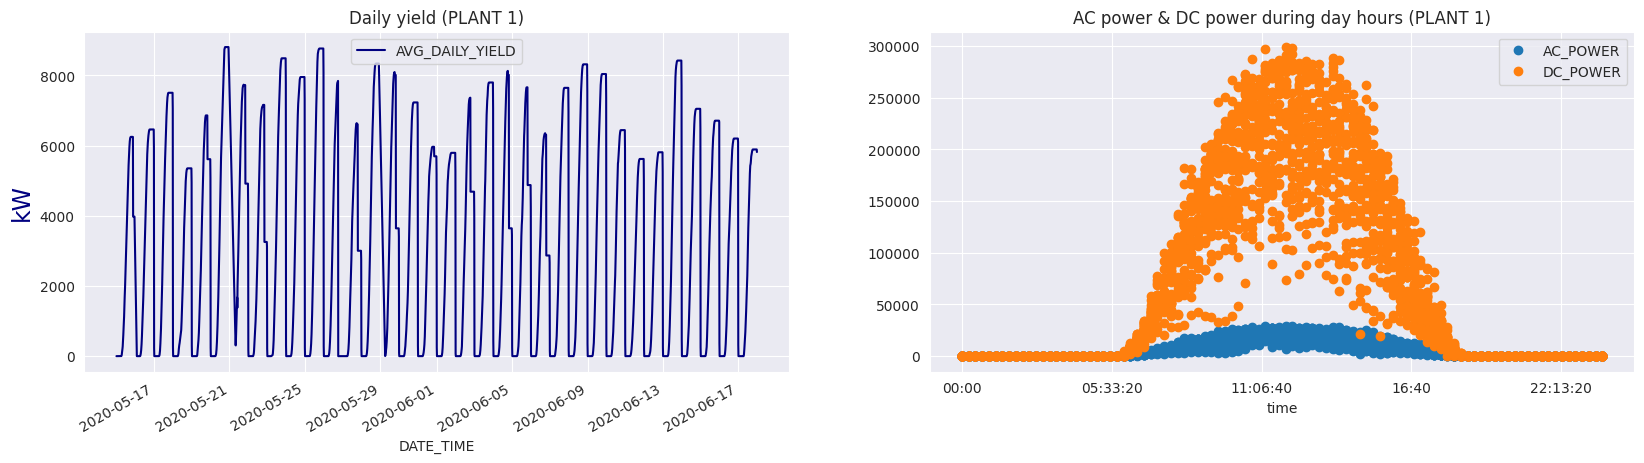

<Axes: xlabel='DATE_TIME'>

<Axes: xlabel='time'>

Text(0.5, 1.0, 'Daily yield (PLANT 2)')

Text(0.5, 1.0, 'AC power & DC power during day hours (PLANT 2)')

Text(0, 0.5, 'kW')

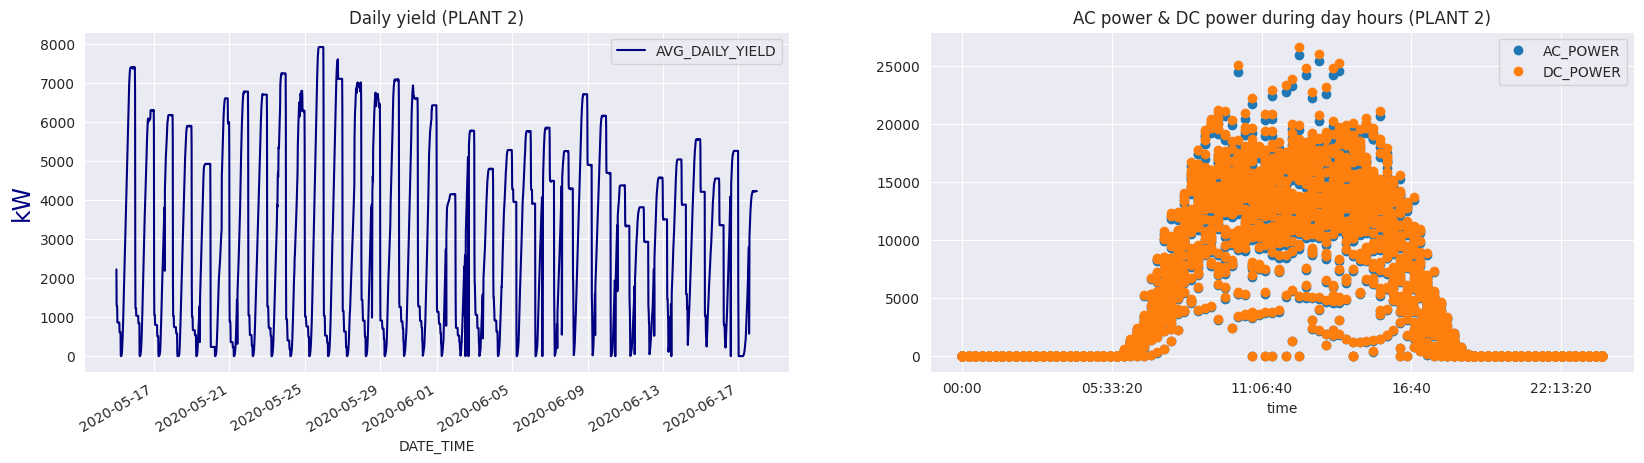

In [ ]:
df1 = df[df['PLANT_ID'] == 4135001]
df2 = df[df['PLANT_ID'] == 4136001]


# Plant 1

fig, ax = plt.subplots(ncols=2,nrows=1,dpi=100,figsize=(20,5))

# plot of AVG_DAILY_YIELD
df1.plot(x='DATE_TIME',y = 'AVG_DAILY_YIELD',color='navy',ax=ax[0])
# AC & DC power plot
df1.set_index('time').drop('DATE_TIME',1)[['AC_POWER','DC_POWER']].plot(style='o',ax=ax[1])

ax[0].set_title('Daily yield (PLANT 1)')
ax[1].set_title('AC power & DC power during day hours (PLANT 1)')
ax[0].set_ylabel('kW',color='navy',fontsize=17)
plt.show()

# Plant 2

fig,ax = plt.subplots(ncols=2,nrows=1,dpi=100,figsize=(20,5))

# plot of AVG_DAILY_YIELD
df2.plot(x='DATE_TIME',y = 'AVG_DAILY_YIELD',color='navy',ax=ax[0])
# AC & DC power plot
df2.set_index('time').drop('DATE_TIME',1)[['AC_POWER','DC_POWER']].plot(style='o',ax=ax[1])

ax[0].set_title('Daily yield (PLANT 2)')
ax[1].set_title('AC power & DC power during day hours (PLANT 2)')
ax[0].set_ylabel('kW',color='navy',fontsize=17)
plt.show()


# Percentage of DC power converted to AC power for Plant 1 and Plant 2

<Axes: xlabel='date'>

Text(0.5, 1.0, '% of DC power converted in AC power (PLANT 1)')

Text(0, 0.5, 'DC power converted (%)')

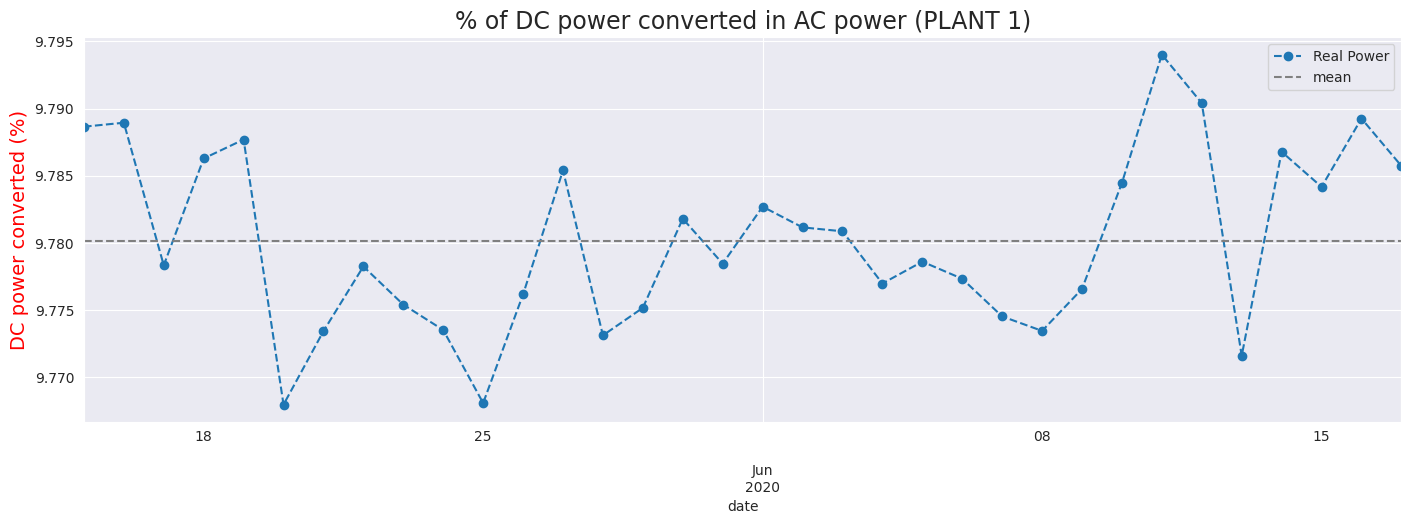

In [ ]:
energy_loss = df1.copy()


energy_loss=energy_loss.groupby('date').sum()


energy_loss['losses']=energy_loss['AC_POWER']/energy_loss['DC_POWER']*100


energy_loss['losses'].plot(style='o--',figsize=(17,5),label='Real Power')

plt.title('% of DC power converted in AC power (PLANT 1)',size=17)
plt.ylabel('DC power converted (%)',fontsize=14,color='red')
plt.axhline(energy_loss['losses'].mean(),linestyle='--',color='gray',label='mean')
plt.legend()
plt.show()

<Axes: xlabel='date'>

Text(0.5, 1.0, '% of DC power converted in AC power (PLANT 2)')

Text(0, 0.5, 'DC power converted (%)')

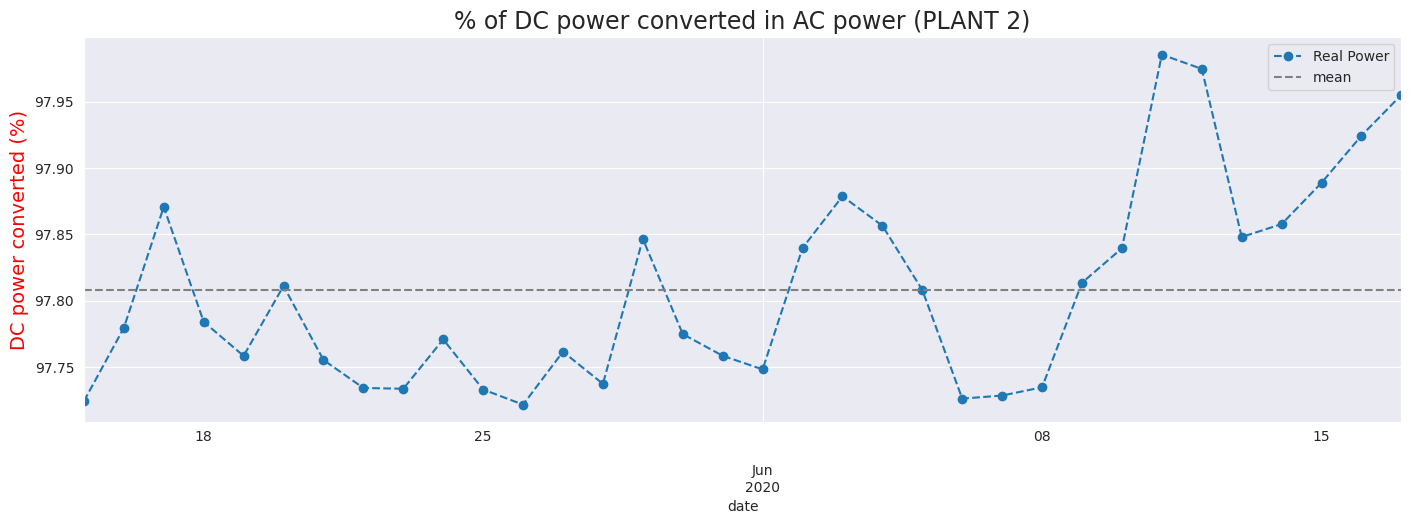

In [ ]:
energy_loss = df2.copy()


energy_loss=energy_loss.groupby('date').sum()


energy_loss['losses']=energy_loss['AC_POWER']/energy_loss['DC_POWER']*100


energy_loss['losses'].plot(style='o--',figsize=(17,5),label='Real Power')

plt.title('% of DC power converted in AC power (PLANT 2)',size=17)
plt.ylabel('DC power converted (%)',fontsize=14,color='red')
plt.axhline(energy_loss['losses'].mean(),linestyle='--',color='gray',label='mean')
plt.legend()
plt.show()

* We can see that Plant 1 is only converting 9.78% of DC Power to AC, whereas Plant 2 is working more efficiently as its averageing about 97.8%

* **So for further analysis, we will only be considering Plant 2**



# Daily Yield for Plant 2

<Axes: xlabel='date'>

Text(0.5, 1.0, 'Daily Yield Plant 2')

Text(0, 0.5, 'kW')

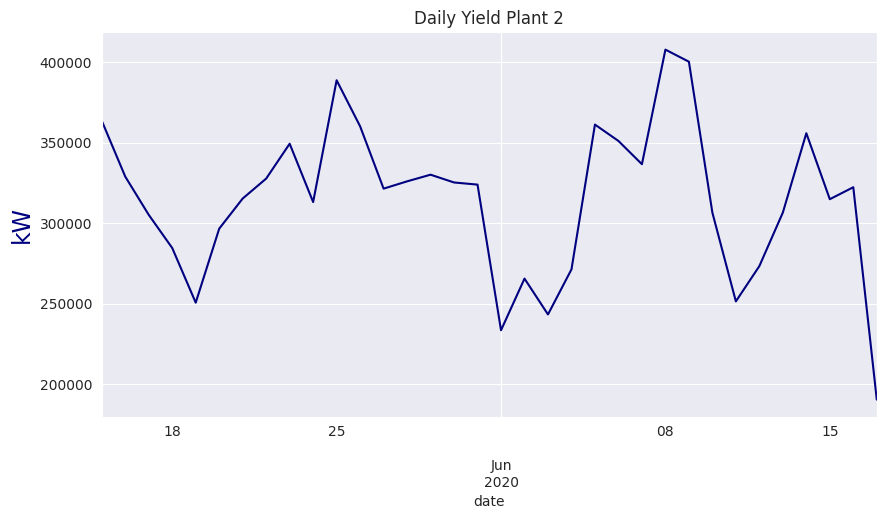

In [ ]:
df2=df2.groupby('date').sum()
fig,ax= plt.subplots(dpi=100,figsize=(10,5))
df2['AVG_DAILY_YIELD'].plot(color='navy')

ax.set_title('Daily Yield Plant 2')
ax.set_ylabel('kW',color='navy',fontsize=17)
plt.show()

# Irradiation Plot for Plant 2

<Axes: xlabel='time'>

Text(0.5, 1.0, 'Irradiation During Day Hours')

Text(0, 0.5, 'W/m')

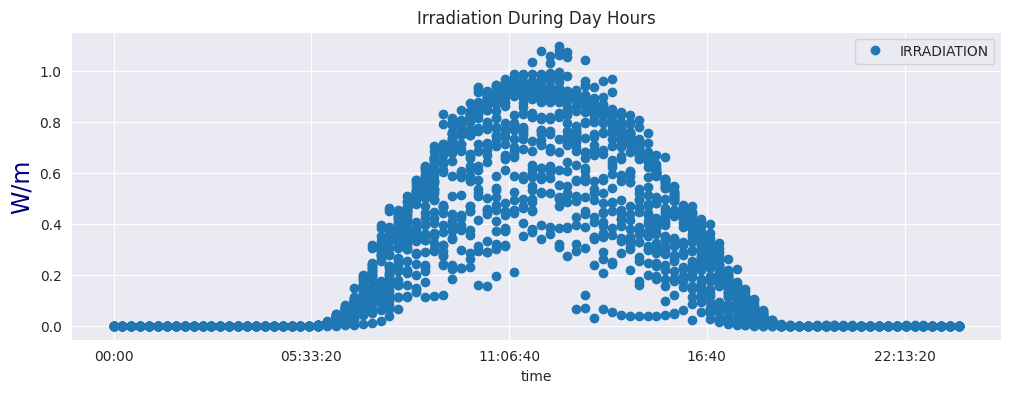

In [ ]:
df2 = df  [df['PLANT_ID']  ==   4136001 ]


fig,ax = plt.subplots(dpi=100,figsize=(12,4))

df2.plot(x='time',y='IRRADIATION',ax=ax,style='o')

ax.set_title('Irradiation During Day Hours')
ax.set_ylabel('W/m',color='navy',fontsize=17)

plt.show()

# Ambient Temperature for Plant 2


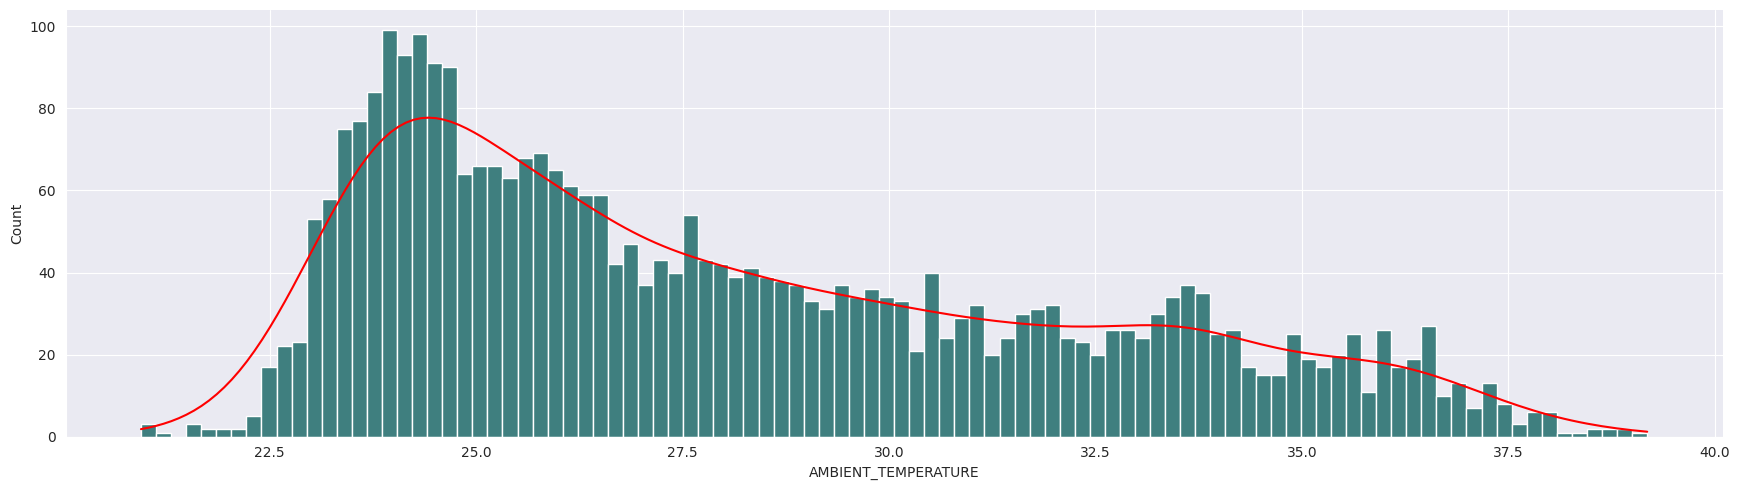

In [ ]:
sns.displot(
    data=df2, x="AMBIENT_TEMPERATURE", kde=True, bins = 100,color = "red", facecolor = "#3F7F7F",
    height = 5, aspect = 3.5)


# Plotting Per Day DC power and AC power generation for Plants 1 and 2

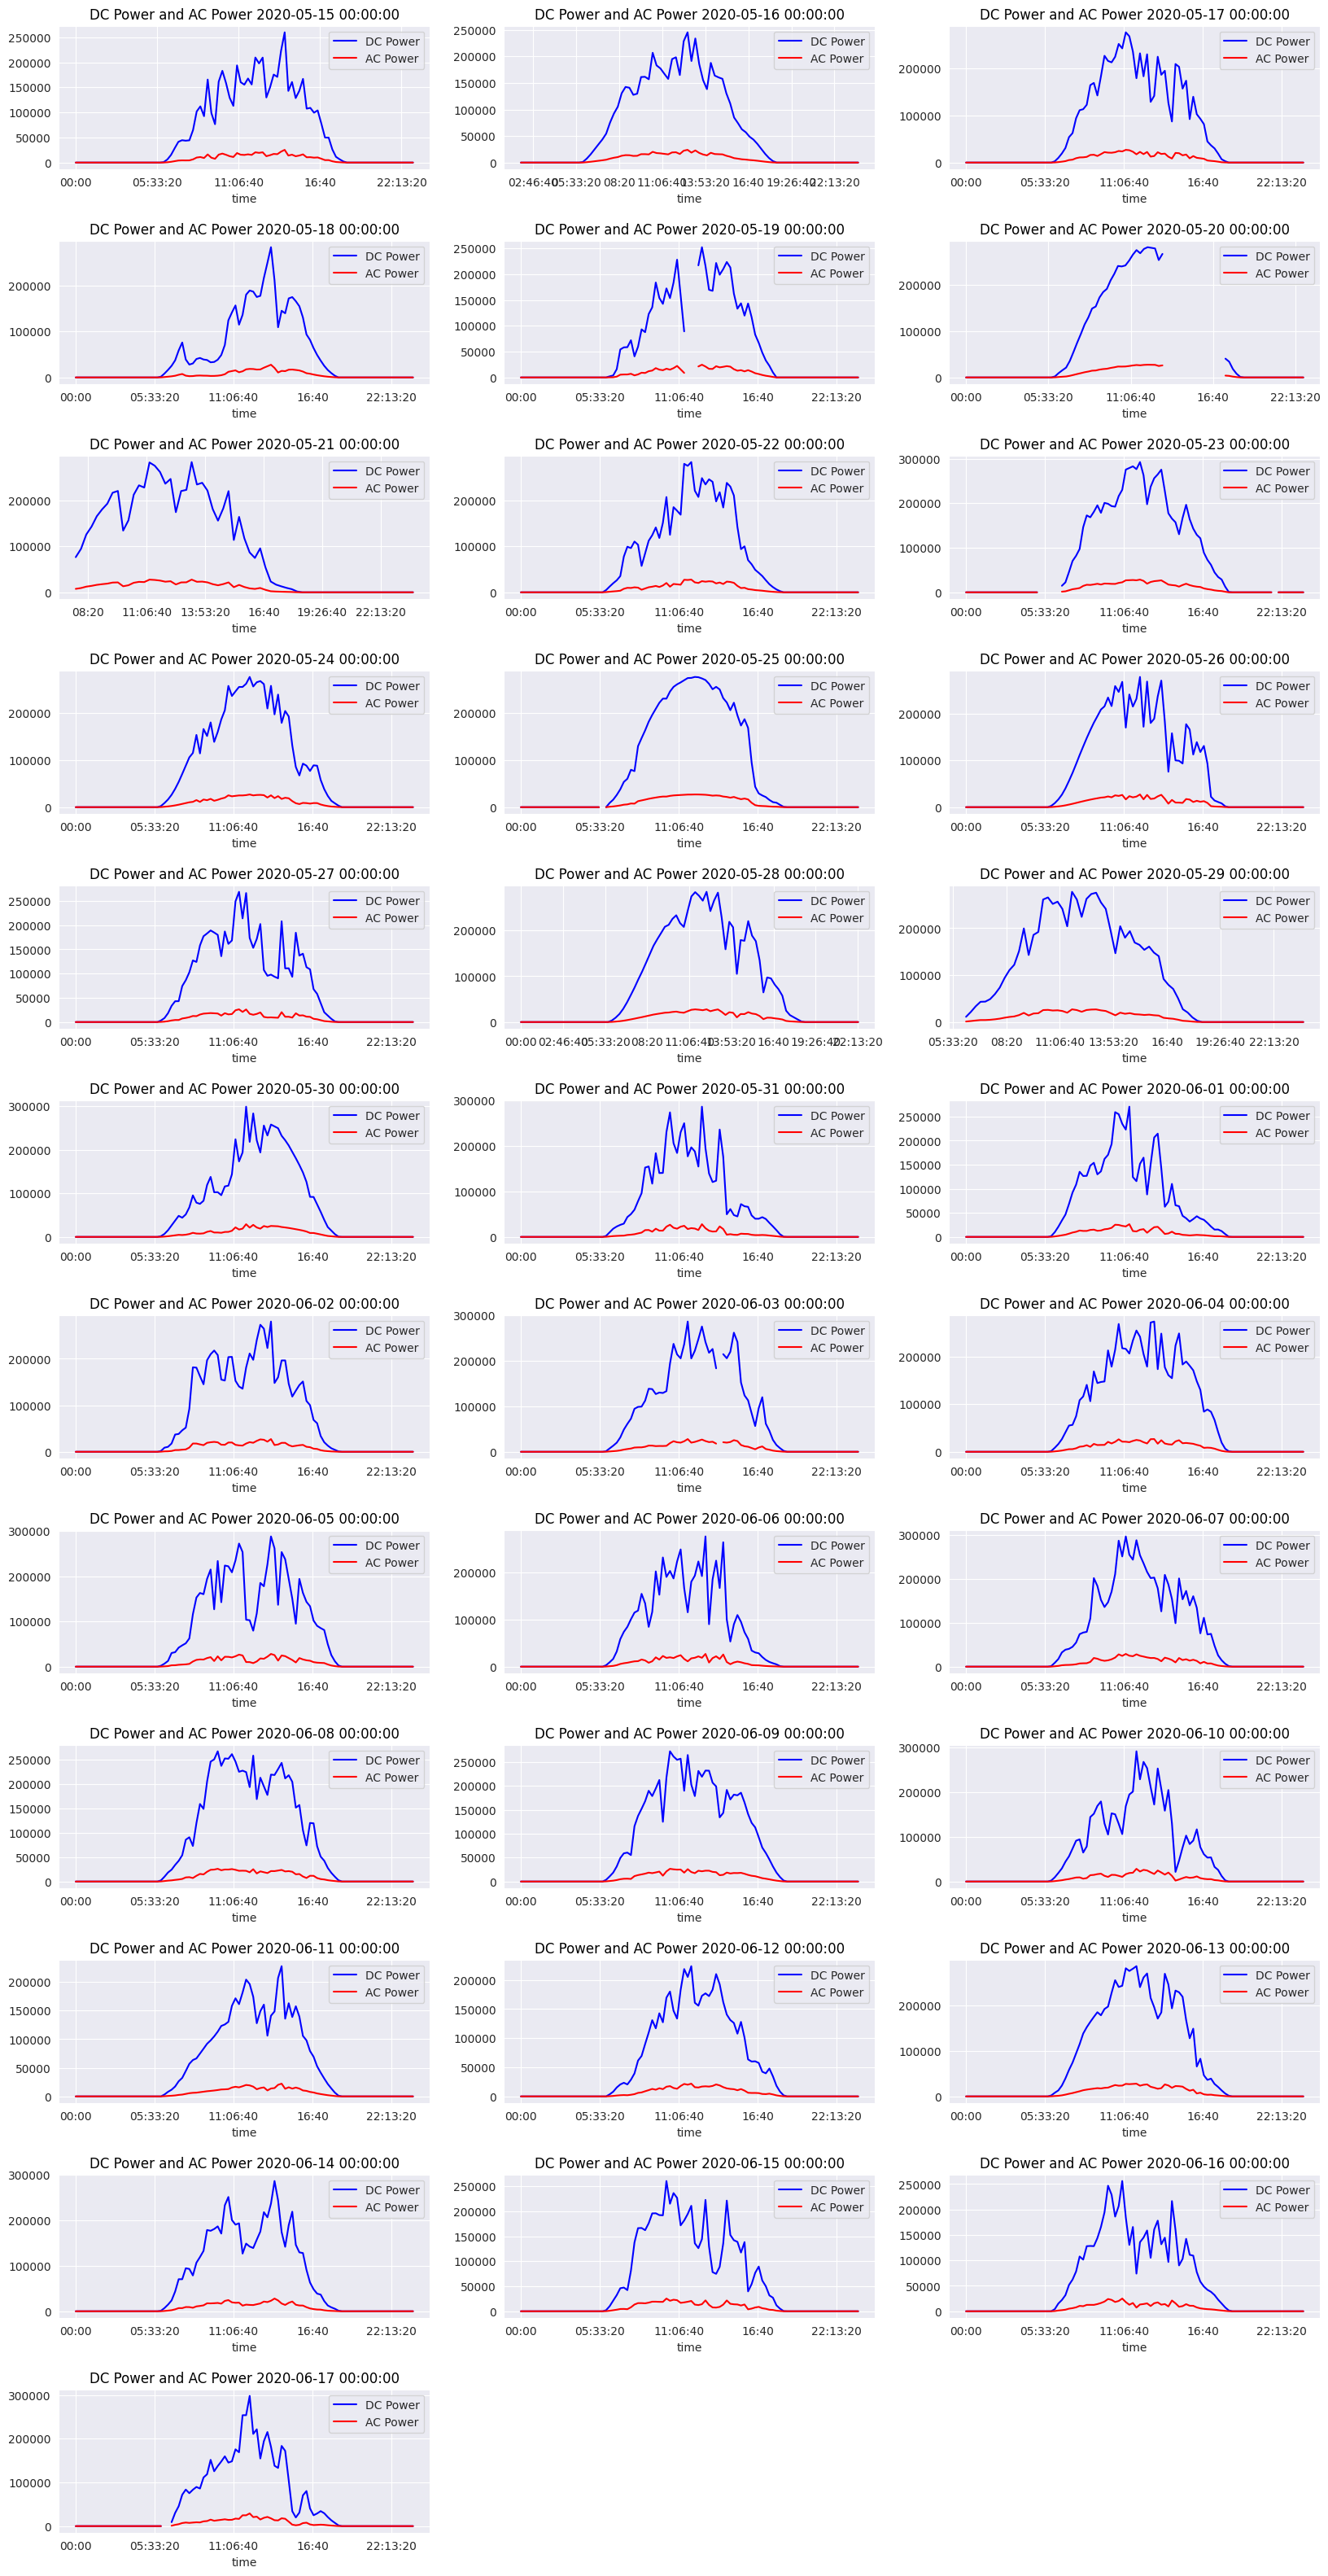

In [ ]:
df1 = df  [df['PLANT_ID']  ==   4135001 ]
df2 = df  [df['PLANT_ID']  ==   4136001 ]


# For plant 1
solar_dc = df1.pivot_table(values='DC_POWER', index='time', columns='date')
solar_temp = df1.pivot_table(values='AC_POWER', index='time', columns='date')

def Daywise_plot(dc_data= None , ac_data=None, row=None, col=None, title='DC Power and AC Power'):
    cols = dc_data.columns  # take all column
    gp = plt.figure(figsize=(20, 40))

    gp.subplots_adjust(wspace=0.2, hspace=0.5)
    for i in range(1, len(cols) + 1):
        ax = gp.add_subplot(row, col, i)
        dc_data[cols[i - 1]].plot(ax=ax, color='blue', label='DC Power')
        ac_data[cols[i - 1]].plot(ax=ax, color='red', label='AC Power')
        ax.set_title('{} {}'.format(title, cols[i - 1]), color='black')
        ax.legend()

Daywise_plot(dc_data=solar_dc, ac_data=solar_temp, row=12, col=3)
plt.show()


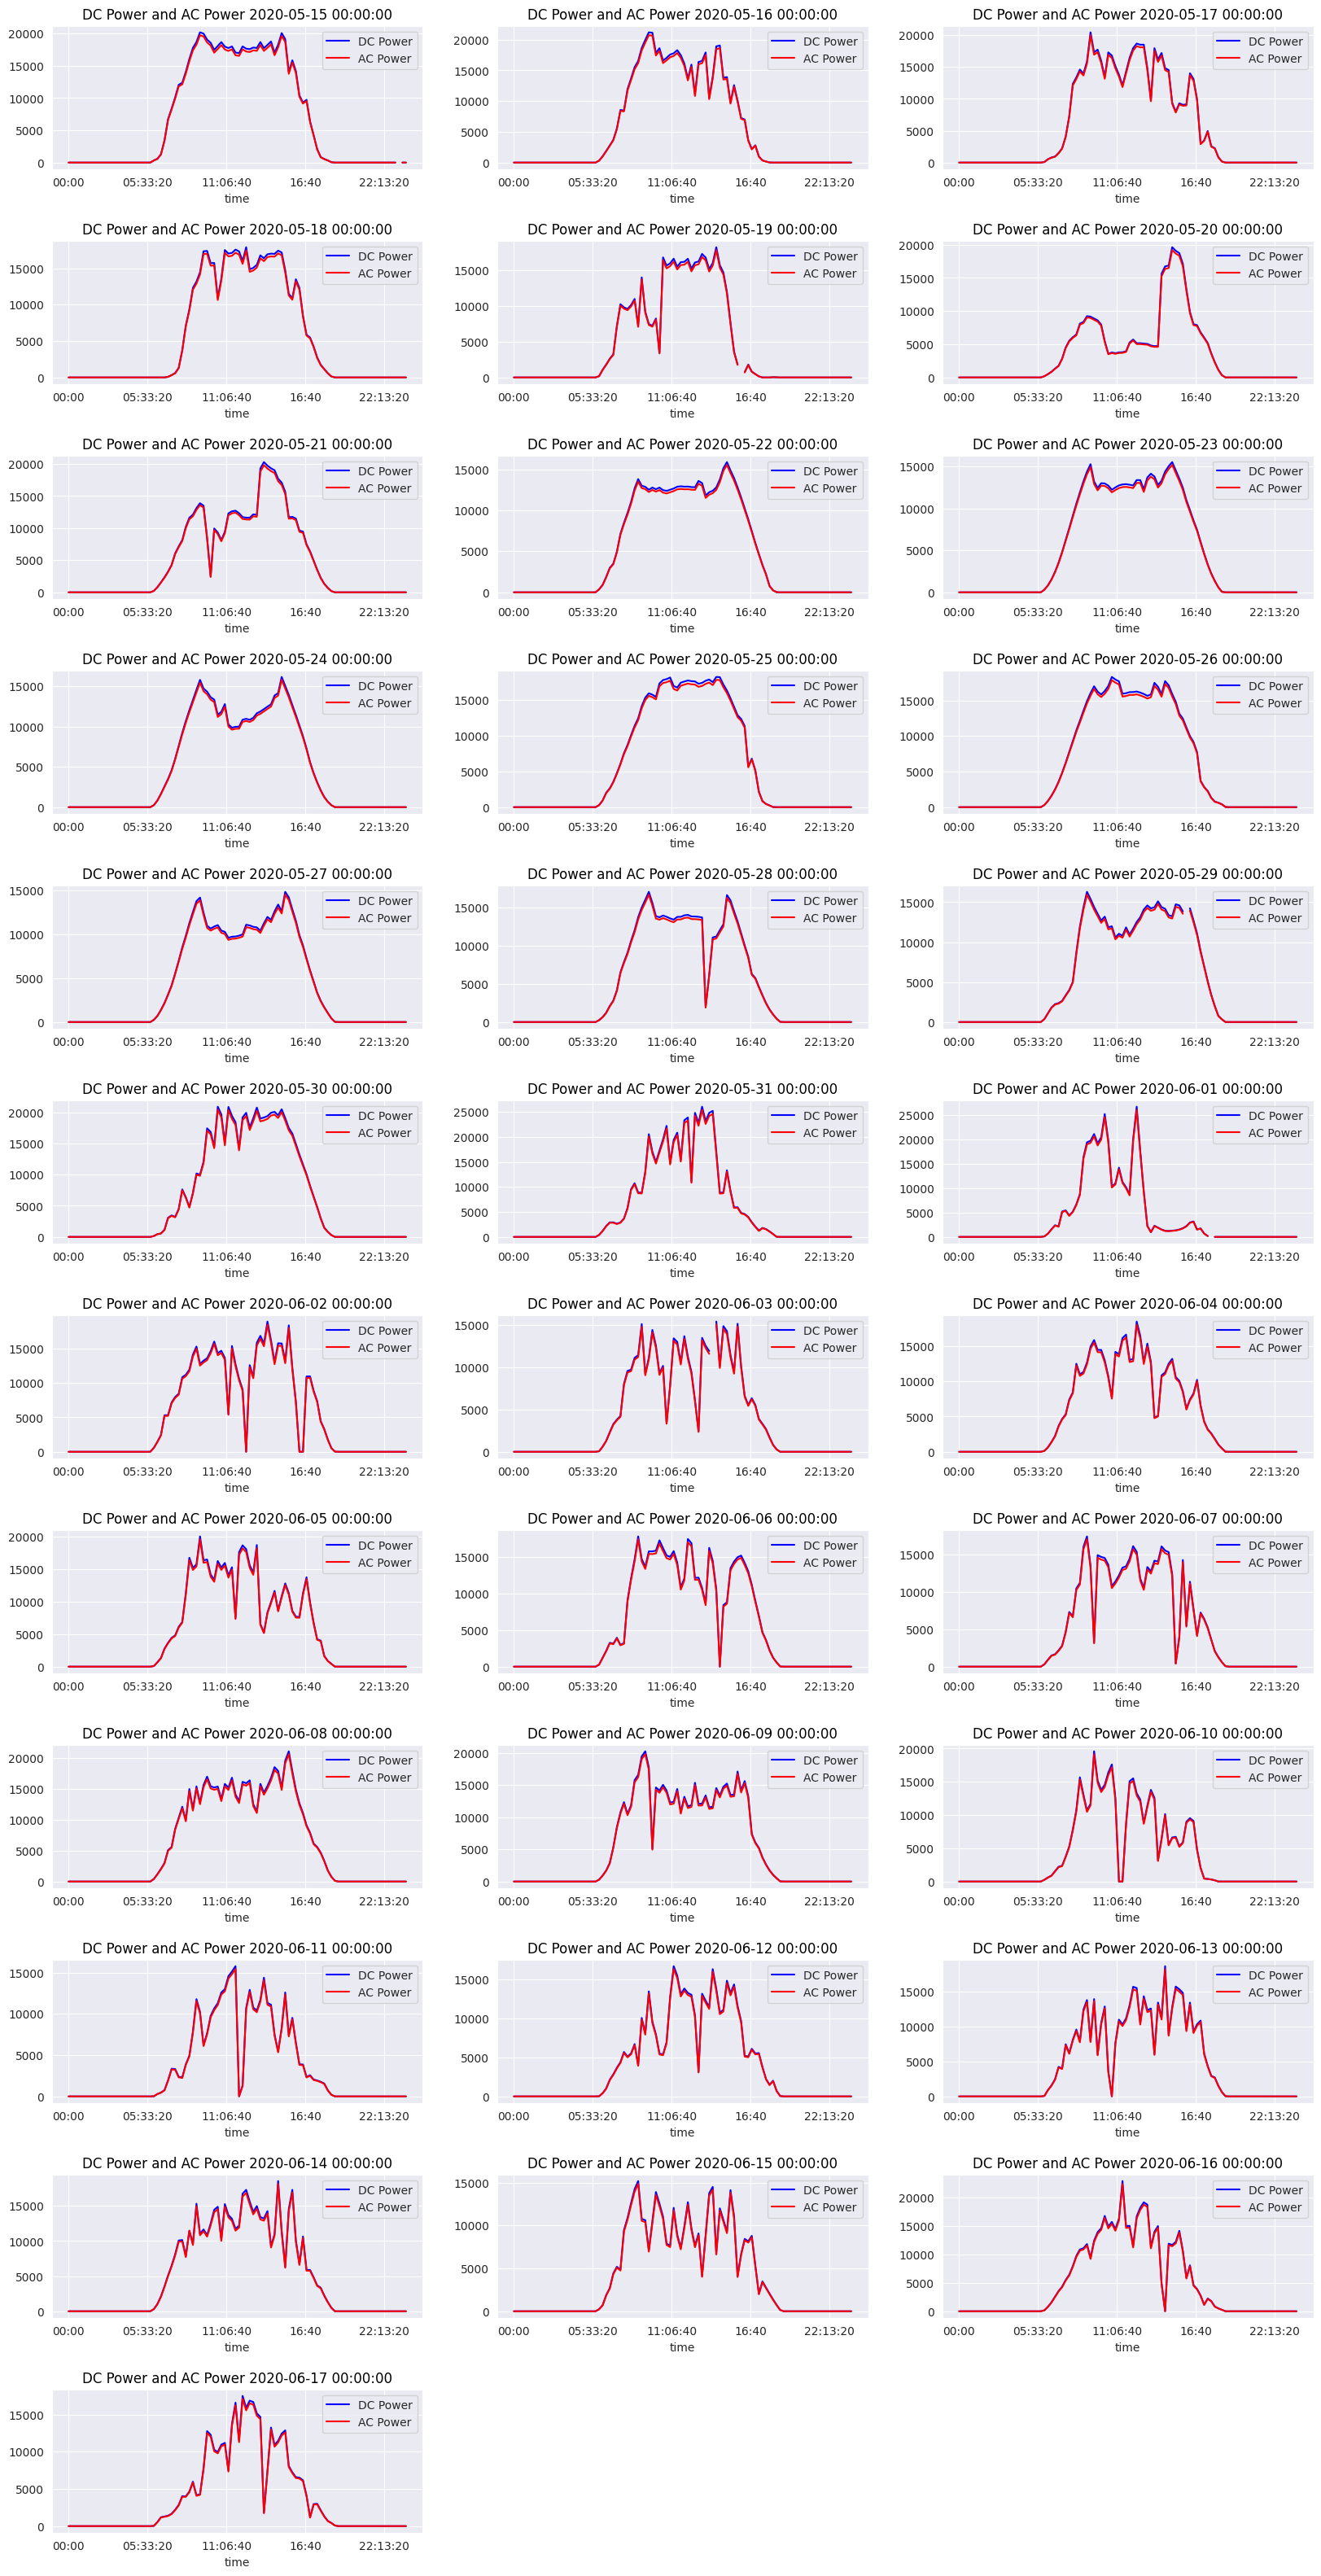

In [ ]:
# For plant 2
solar_dc = df2.pivot_table(values='DC_POWER', index='time', columns='date')
solar_temp = df2.pivot_table(values='AC_POWER', index='time', columns='date')

def Daywise_plot(dc_data= None , ac_data=None, row=None, col=None, title='DC Power and AC Power'):
    cols = dc_data.columns  # take all column
    gp = plt.figure(figsize=(20, 40))

    gp.subplots_adjust(wspace=0.2, hspace=0.5)
    for i in range(1, len(cols) + 1):
        ax = gp.add_subplot(row, col, i)
        dc_data[cols[i - 1]].plot(ax=ax, color='blue', label='DC Power')
        ac_data[cols[i - 1]].plot(ax=ax, color='red', label='AC Power')
        ax.set_title('{} {}'.format(title, cols[i - 1]), color='black')
        ax.legend()

Daywise_plot(dc_data=solar_dc, ac_data=solar_temp, row=12, col=3)
plt.show()


**We can see very clearly that Plant 1 is nowhere near as efficient as Plant 2 in converting DC to AC**

DC Power vs Module Temperature for Plant 2

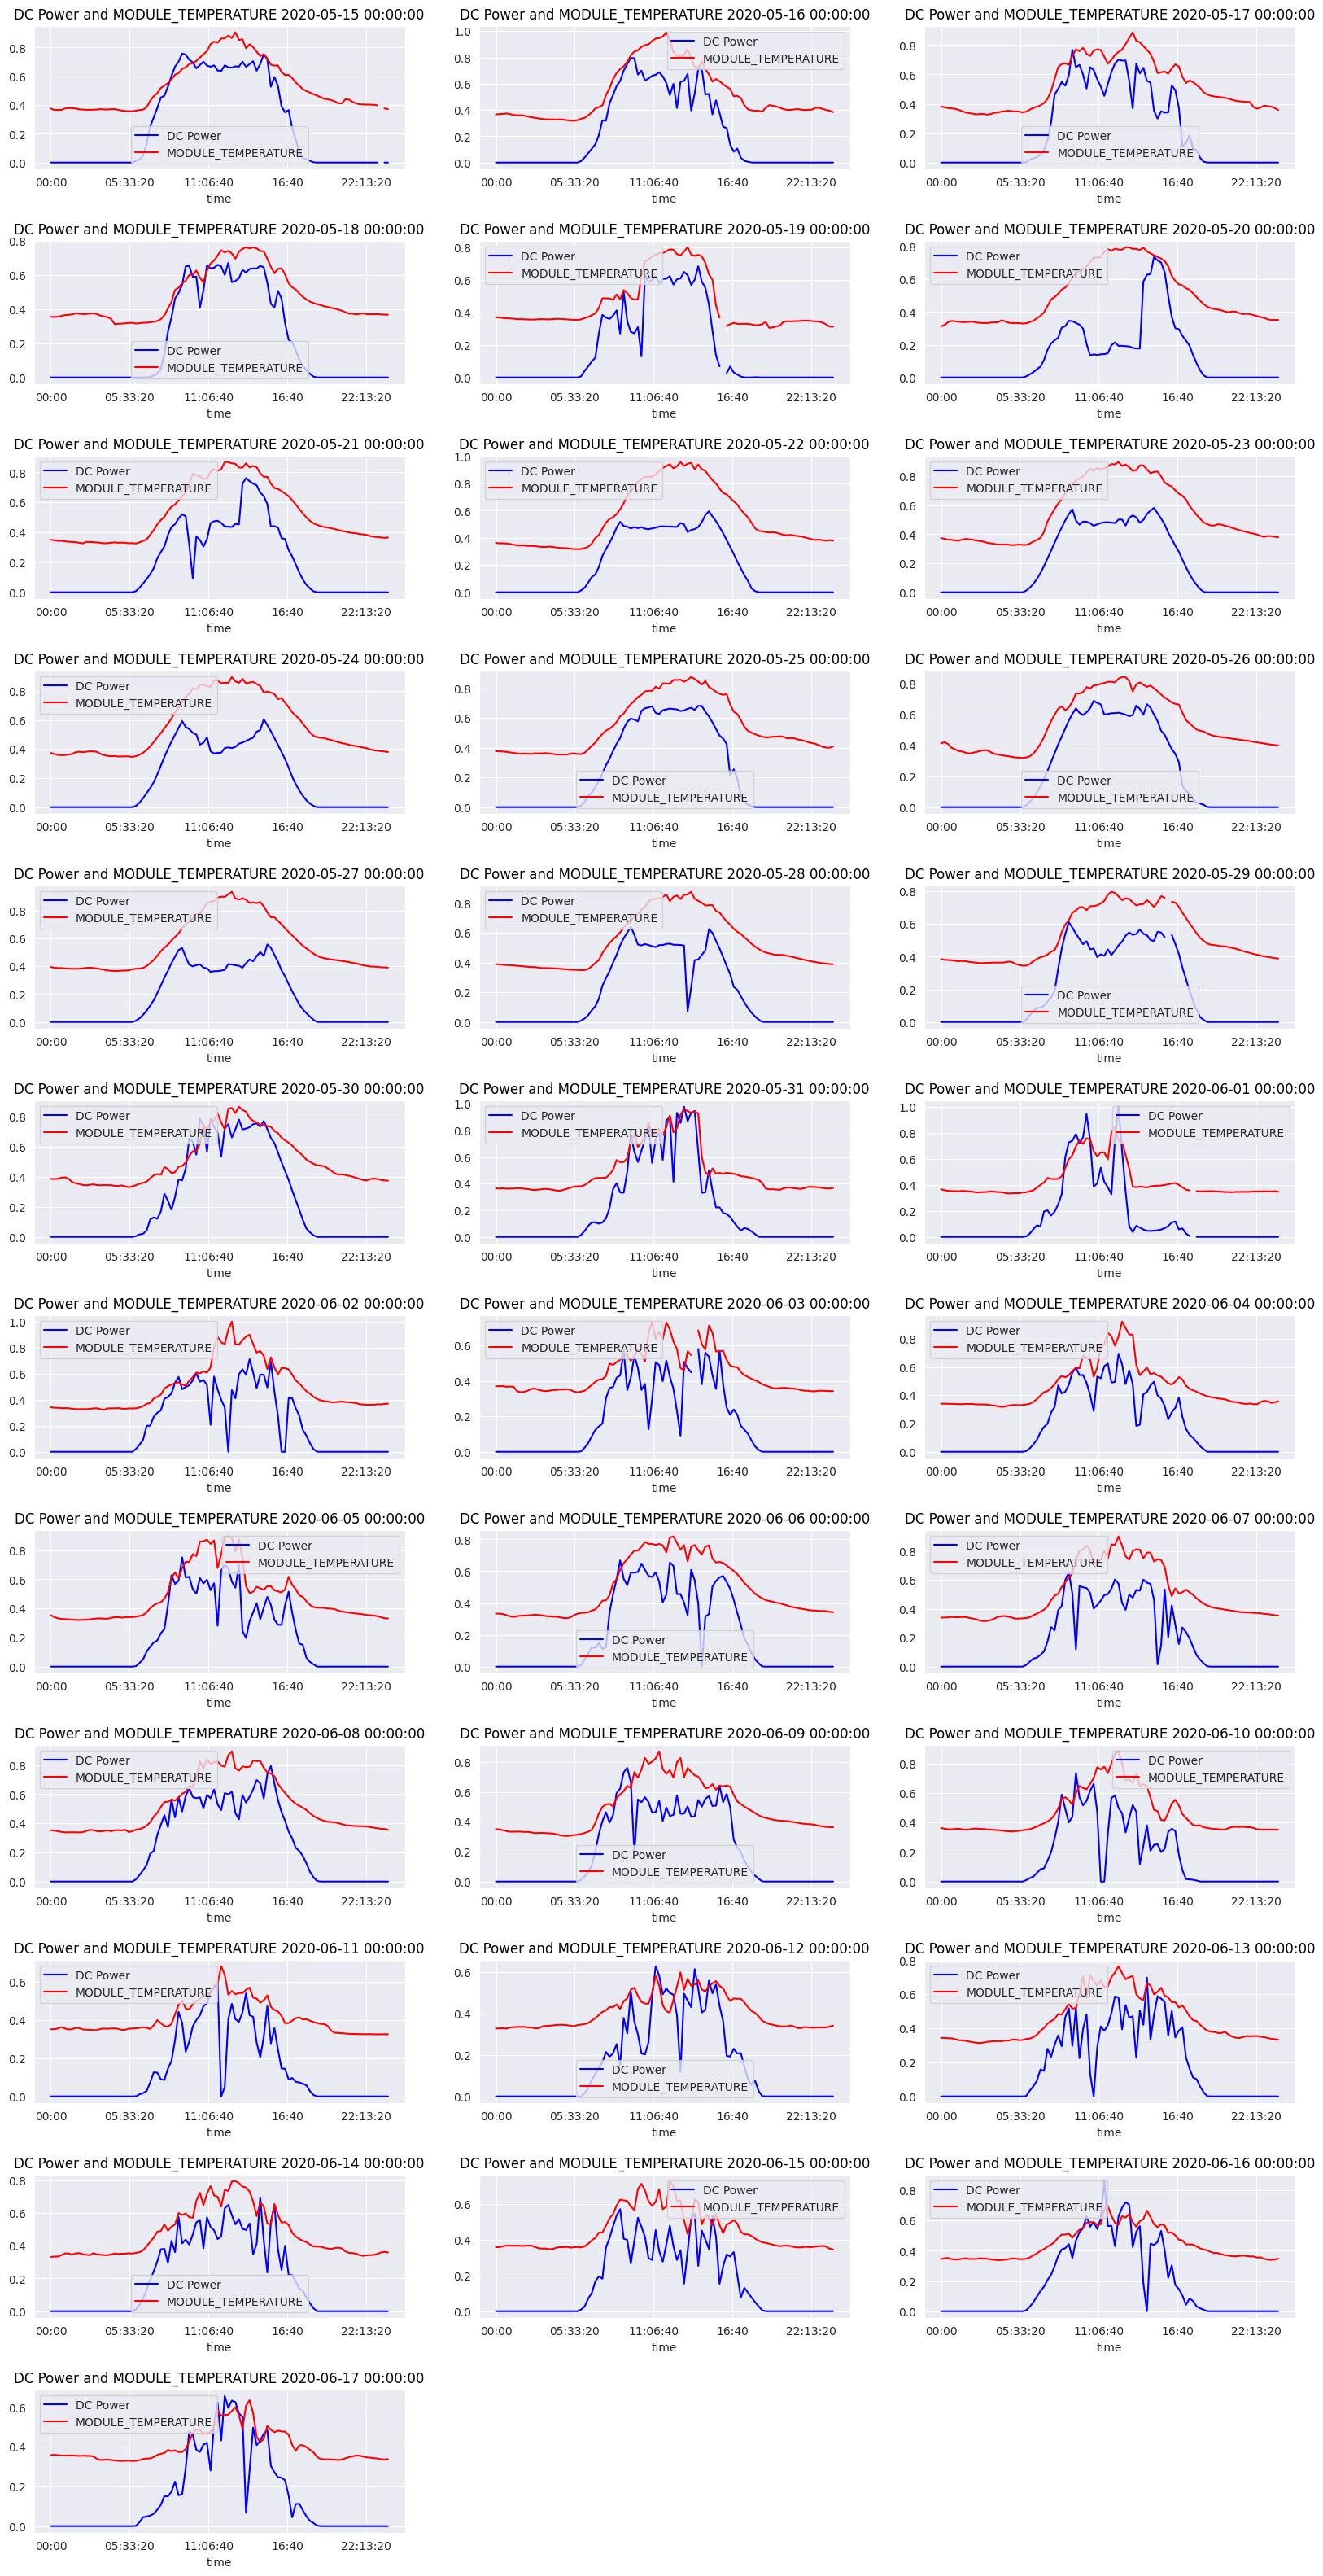

In [ ]:
df2['DC_POWER'] = df2['DC_POWER'] / df2['DC_POWER'].max()
df2['MODULE_TEMPERATURE'] = df2['MODULE_TEMPERATURE'] / df2['MODULE_TEMPERATURE'].max()

solar_dc = df2.pivot_table(values='DC_POWER', index='time', columns='date')
solar_temp = df2.pivot_table(values='MODULE_TEMPERATURE', index='time', columns='date')

def Daywise_plot(dc_data= None , ac_data=None, row=None, col=None, title='DC Power and MODULE_TEMPERATURE'):
    cols = dc_data.columns
    gp = plt.figure(figsize=(20, 40))

    gp.subplots_adjust(wspace=0.2, hspace=0.5)
    for i in range(1, len(cols) + 1):
        ax = gp.add_subplot(row, col, i)
        dc_data[cols[i - 1]].plot(ax=ax, color='blue', label='DC Power')
        ac_data[cols[i - 1]].plot(ax=ax, color='red', label='MODULE_TEMPERATURE')
        ax.set_title('{} {}'.format(title, cols[i - 1]), color='black')
        ax.legend()

Daywise_plot(dc_data=solar_dc, ac_data=solar_temp, row=12, col=3)
plt.show()


We can see that every morning(corresponding to the sunrise), the DC power generation and the solar module temperature starts to rise significantly, right up until the sun starts to set.

Irradiation vs DC Power for Plant 2

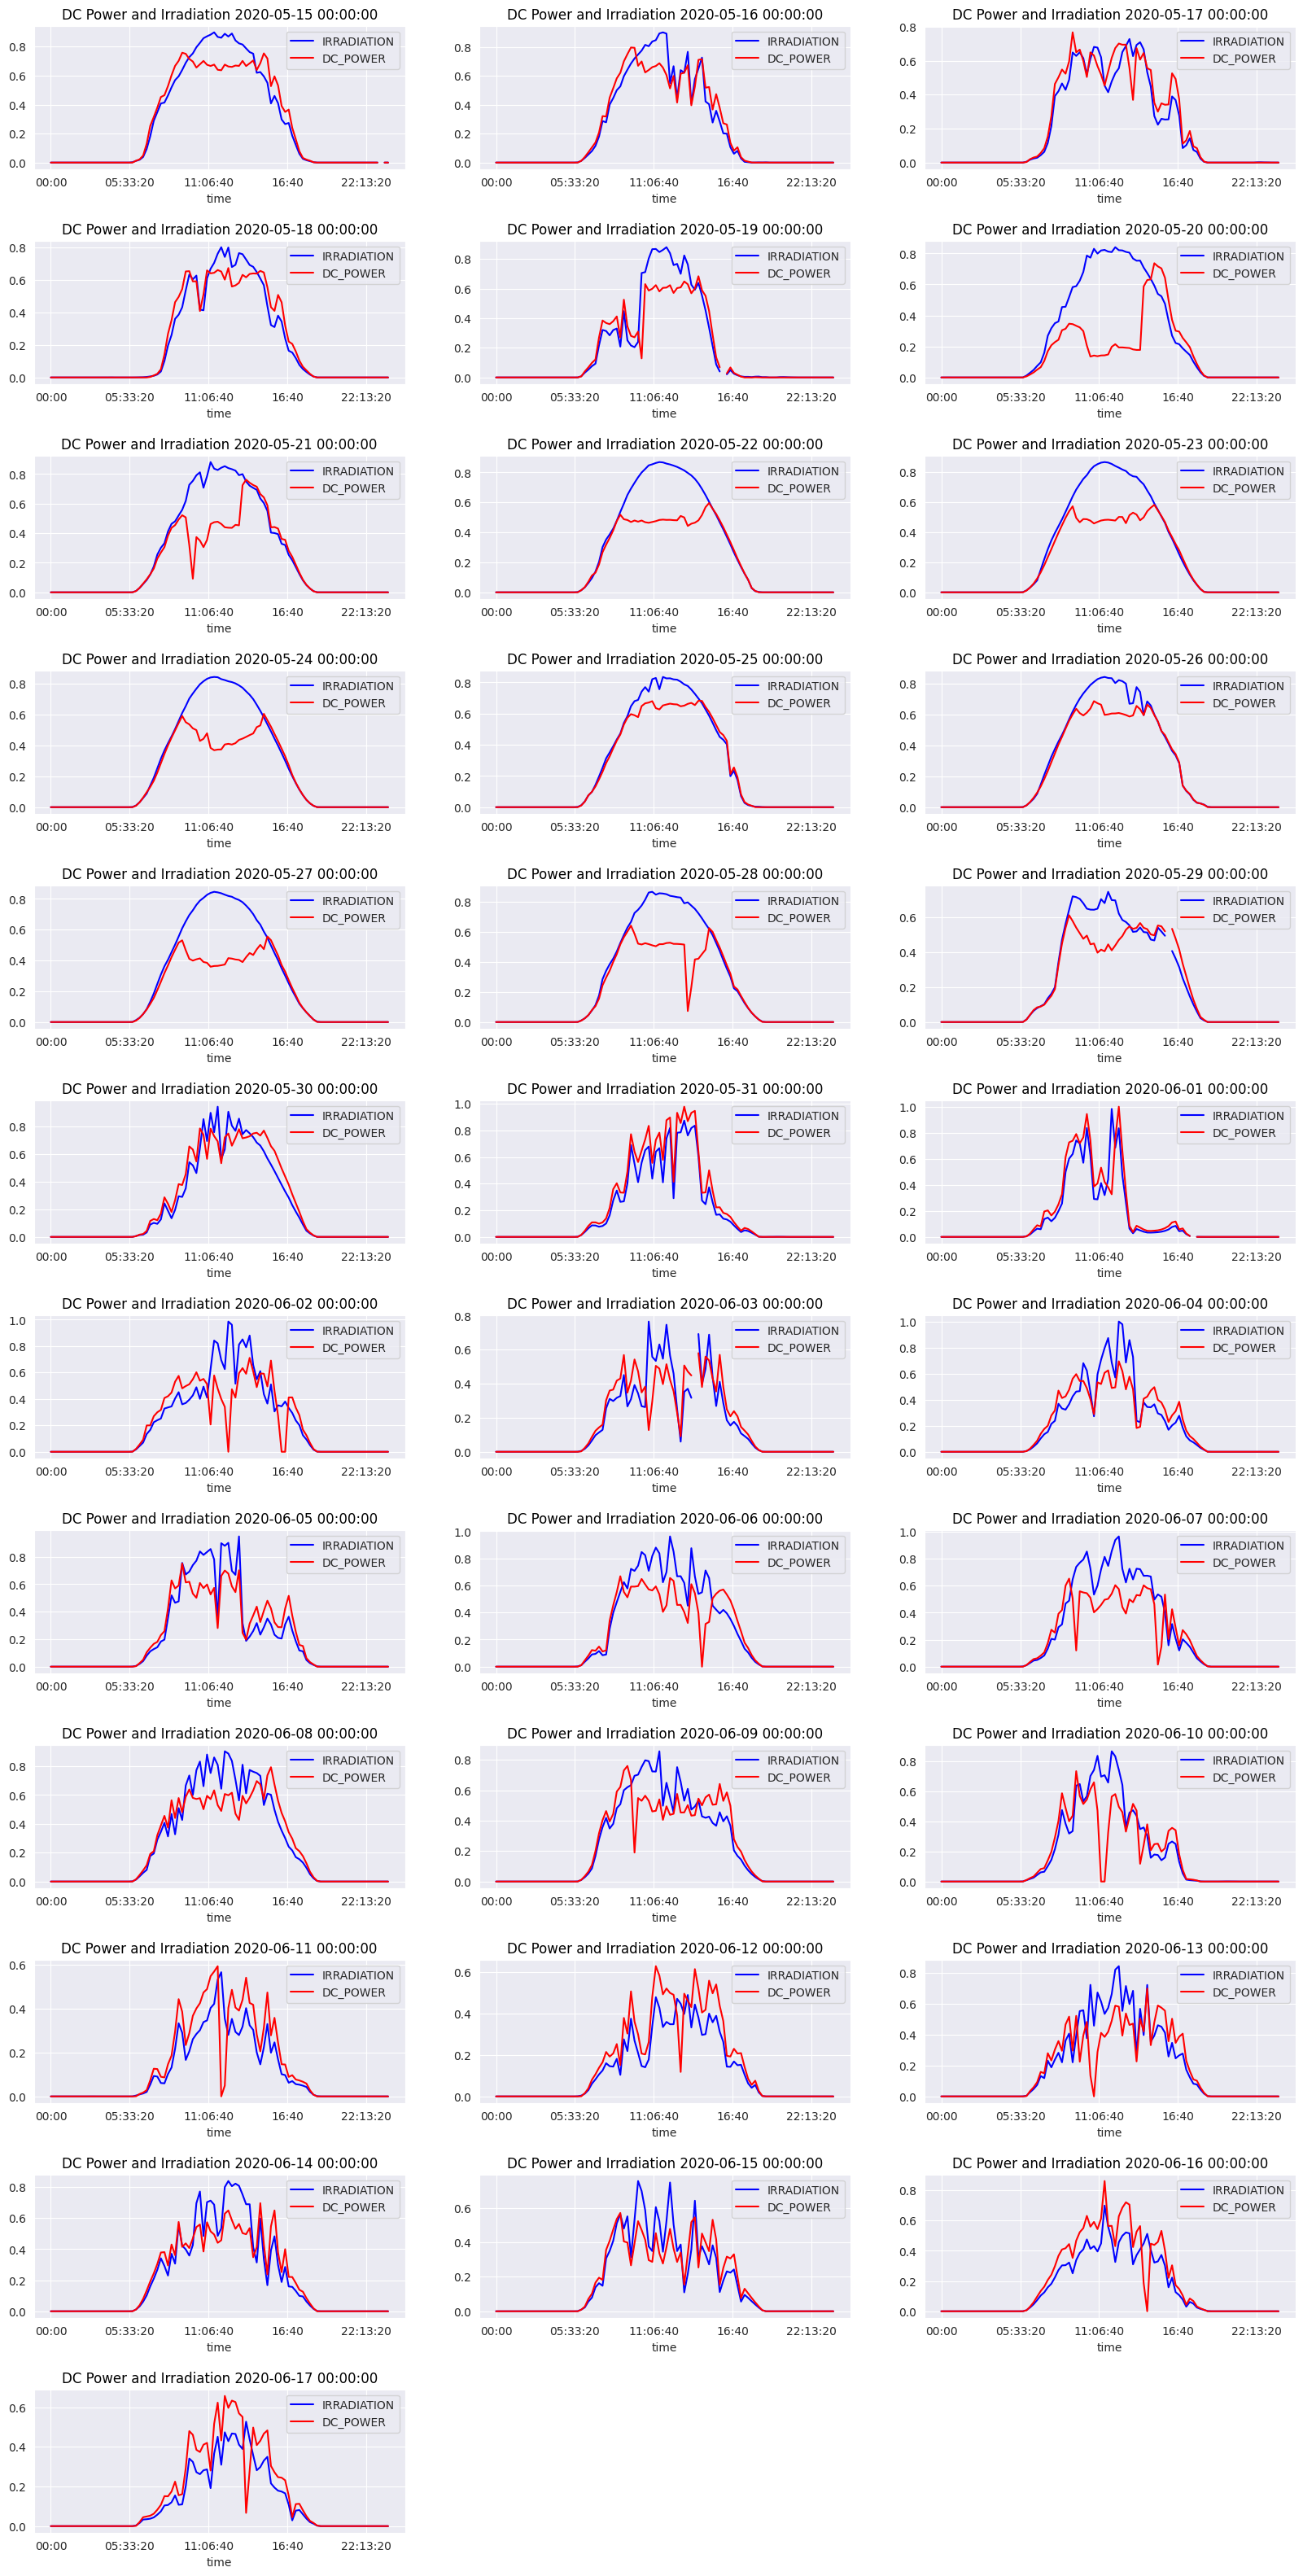

In [ ]:
df2['IRRADIATION'] = df2['IRRADIATION'] / df2['IRRADIATION'].max()
df2['DC_POWER'] = df2['DC_POWER'] / df2['DC_POWER'].max()

solar_dc = df2.pivot_table(values='IRRADIATION', index='time', columns='date')
solar_temp = df2.pivot_table(values='DC_POWER', index='time', columns='date')

def Daywise_plot(dc_data= None , ac_data=None, row=None, col=None, title='DC Power and Irradiation'):
    cols = dc_data.columns
    gp = plt.figure(figsize=(20, 40))

    gp.subplots_adjust(wspace=0.2, hspace=0.5)
    for i in range(1, len(cols) + 1):
        ax = gp.add_subplot(row, col, i)
        dc_data[cols[i - 1]].plot(ax=ax, color='blue', label='IRRADIATION')
        ac_data[cols[i - 1]].plot(ax=ax, color='red', label='DC_POWER')
        ax.set_title('{} {}'.format(title, cols[i - 1]), color='black')
        ax.legend()

Daywise_plot(dc_data=solar_dc, ac_data=solar_temp, row=12, col=3)
plt.show()

Correlation Heat Map for Plant 2

<Figure size 1200x1000 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Correlation Matrix')

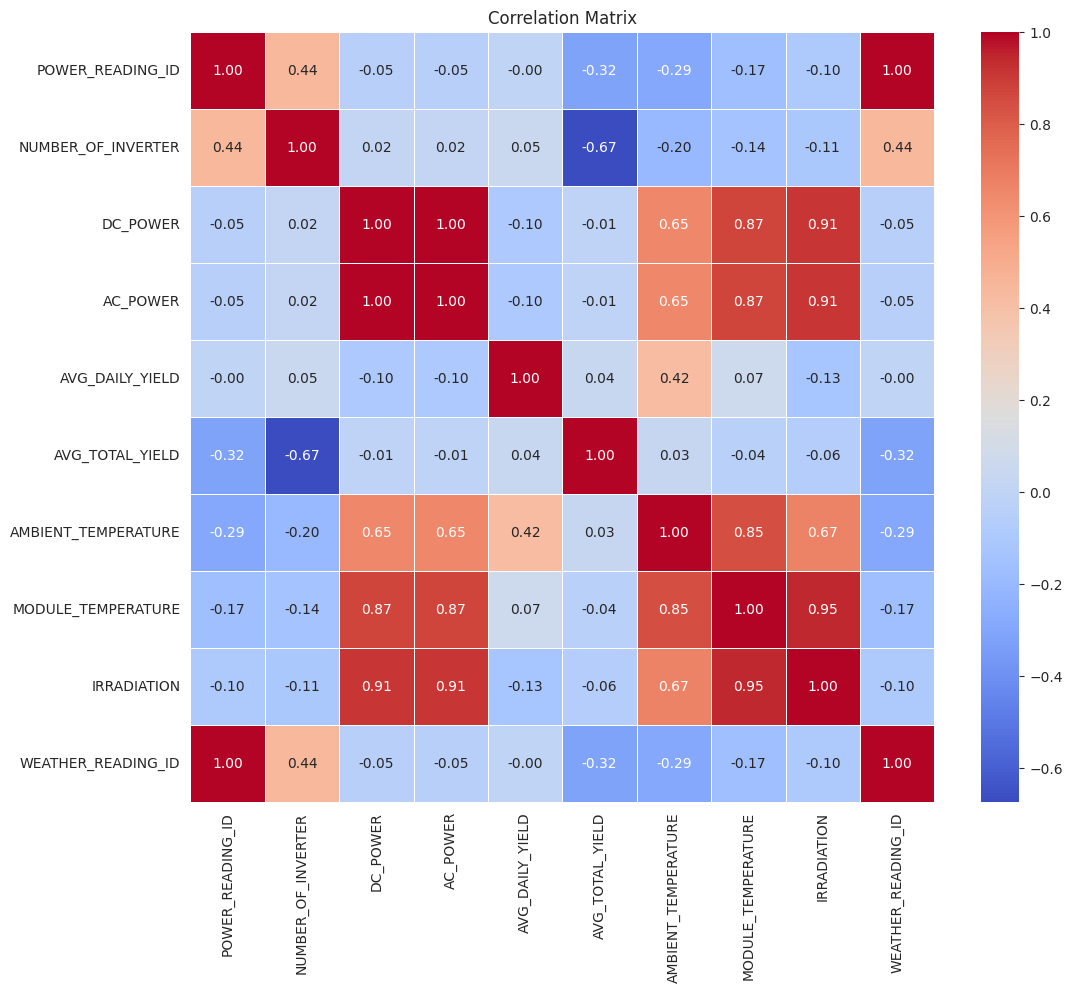

In [ ]:
#Plant 2
df2_temp = df2.drop('PLANT_ID', axis = 1)

correlation_matrix = df2_temp.corr()



plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix')
plt.show()


We can see that DC_Power has a good correlation with Ambient_Temperature, Module_Temperature, and Irradiation!

# Machine Learning

The goal of this model is to predict what the DC Power output would be on a given day. This requires that a user have a forecast for the next day (or few days) and they can then put that information into this model to get a prediction of the power output.

In [ ]:
# import essential models

from sklearn.preprocessing import scale
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
import datetime as dt

# Feature Engineering

In [ ]:
# Separating hours and minutes and converting to int type so they can be used for our model

df2['hour']=df2.time.astype(str).str[:2].astype(int)
df2['mins']=df2.time.astype(str).str[3:5].astype(int)
df2.head()

POWER_READING_ID           DATE_TIME  PLANT_ID  NUMBER_OF_INVERTER  \
1                 2 2020-05-15 00:00:00   4136001                  22   
3                 4 2020-05-15 00:15:00   4136001                  22   
5                 6 2020-05-15 00:30:00   4136001                  22   
7                 8 2020-05-15 00:45:00   4136001                  22   
8                 9 2020-05-15 01:00:00   4136001                  22   

   DC_POWER  AC_POWER  AVG_DAILY_YIELD  AVG_TOTAL_YIELD  AMBIENT_TEMPERATURE  \
1       0.0       0.0      2222.724459     6.449816e+08            27.004764   
3       0.0       0.0      1290.954545     6.449816e+08            26.880811   
5       0.0       0.0      1290.954545     6.449816e+08            26.682055   
7       0.0       0.0      1290.954545     6.449816e+08            26.500589   
8       0.0       0.0      1205.272727     6.449816e+08            26.596148   

   MODULE_TEMPERATURE  IRRADIATION  WEATHER_READING_ID      time       date  \
1            0.376085          0.0                   2  00:00:00 2020-05-15   
3            0.366497          0.0                   3  00:15:00 2020-05-15   
5            0.366578          0.0                   5  00:30:00 2020-05-15   
7            0.366479          0.0                   7  00:45:00 2020-05-15   
8            0.376497          0.0                  10  01:00:00 2020-05-15   

   hour  mins  
1     0     0  
3     0    15  
5     0    30  
7     0    45  
8     1     0

In [ ]:
# Dropping extra features that are not needed

df2_red = df2.drop(['PLANT_ID','NUMBER_OF_INVERTER','AC_POWER','AVG_DAILY_YIELD','AVG_TOTAL_YIELD','time','date'],axis=1)
df2_red.head()

POWER_READING_ID           DATE_TIME  DC_POWER  AMBIENT_TEMPERATURE  \
1                 2 2020-05-15 00:00:00       0.0            27.004764   
3                 4 2020-05-15 00:15:00       0.0            26.880811   
5                 6 2020-05-15 00:30:00       0.0            26.682055   
7                 8 2020-05-15 00:45:00       0.0            26.500589   
8                 9 2020-05-15 01:00:00       0.0            26.596148   

   MODULE_TEMPERATURE  IRRADIATION  WEATHER_READING_ID  hour  mins  
1            0.376085          0.0                   2     0     0  
3            0.366497          0.0                   3     0    15  
5            0.366578          0.0                   5     0    30  
7            0.366479          0.0                   7     0    45  
8            0.376497          0.0                  10     1     0

<Axes: xlabel='AMBIENT_TEMPERATURE'>

<Axes: xlabel='AMBIENT_TEMPERATURE'>

Text(0.5, 0, 'Ambient Temperature (°C)')

Text(0.5, 0, 'Ambient Temperature (°C)')

Text(0, 0.5, 'Irradiation')

Text(0, 0.5, 'DC Power(KW)')

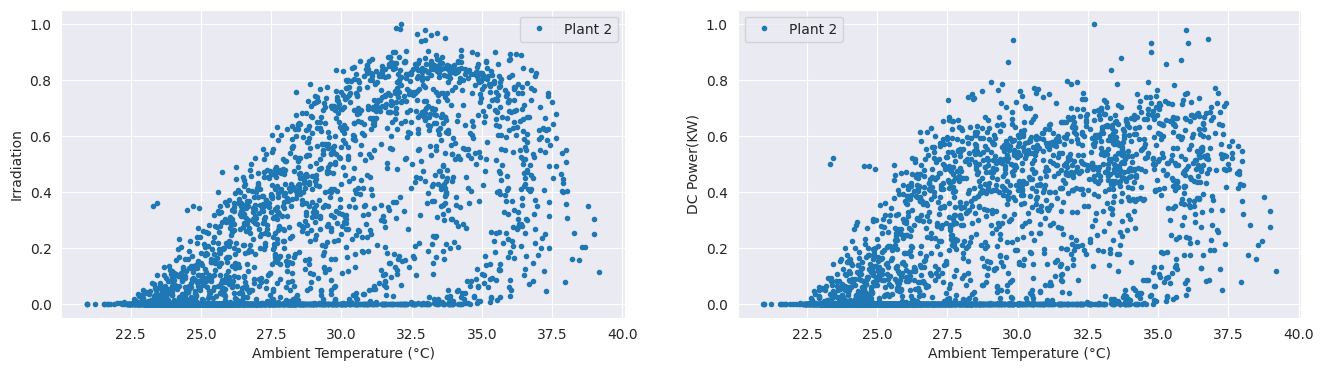

In [ ]:
#Visualizing the correlation between the Ambient Temperature and Irradiation

fig, axs = plt.subplots(ncols=2,nrows=1,figsize=(16,4),sharex=True)
df2_red.plot(x="AMBIENT_TEMPERATURE",y="IRRADIATION",style='.',label="Plant 2",ax=axs[0])
df2_red.plot(x="AMBIENT_TEMPERATURE",y="DC_POWER",style='.',label="Plant 2",ax=axs[1])
axs[0].set_xlabel('Ambient Temperature (°C)')
axs[1].set_xlabel('Ambient Temperature (°C)')
axs[0].set_ylabel('Irradiation')
axs[1].set_ylabel('DC Power(KW)')

In [ ]:
# Performing train-test split

def ts_split(X,y,test_size=0.25):

    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))

    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]

    return X_train, X_test, y_train, y_test

### LINEAR REGRESSION

In [ ]:
X2_lm = df2.loc[:,("hour",'mins',"AMBIENT_TEMPERATURE","MODULE_TEMPERATURE","IRRADIATION")]
y2_lm = df2["DC_POWER"]


X2_train_lm, X2_test_lm, y2_train_lm, y2_test_lm = ts_split(X2_lm,y2_lm)

lr2 = LinearRegression()
lr2.fit(X2_train_lm,y2_train_lm)
y2_pred_lm = lr2.predict(X2_test_lm)
print(lr2.score(X2_test_lm,y2_test_lm))

y2_full_pred_lm = lr2.predict(X2_lm)

LinearRegression()

0.7727793740269868


Using Linear Regression, the **R2 Score** is approximately **78 %**

### Gradient Boost Model

GradientBoostingRegressor(max_depth=6, min_samples_split=5, n_estimators=500)

Regression score for Plant 2 = 0.88
MSE for Plant 2 = 0.00


<Axes: xlabel='DATE_TIME'>

Text(0.5, 0, 'Date/Time')

Text(0, 0.5, 'DC Power (kW)')

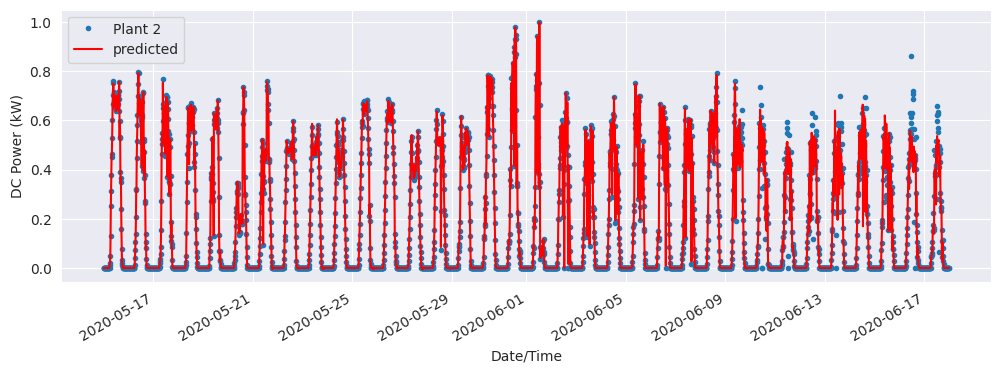

In [ ]:
X2 = df2.loc[:,("hour",'mins',"AMBIENT_TEMPERATURE","MODULE_TEMPERATURE","IRRADIATION")]
y2 = df2["DC_POWER"]


X2_train, X2_test, y2_train, y2_test = ts_split(X2,y2)

params = {'n_estimators': 500,
          'max_depth': 6,
          'min_samples_split': 5}
model2 = GradientBoostingRegressor(**params)
model2.fit(X2_train,y2_train)

y2_pred = model2.predict(X2_test)

print(f'Regression score for Plant 2 = {r2_score(y2_pred,y2_test):.2f}')
print(f'MSE for Plant 2 = {mean_squared_error(y2_pred,y2_test):.2f}')

fig, ax = plt.subplots(figsize=(12,4),sharex=True)
df2_red.plot(x="DATE_TIME",y="DC_POWER",style='.',label="Plant 2",ax=ax)
ax.plot(df2.DATE_TIME.values,model2.predict(X2),'r-',label='predicted')
ax.set_xlabel('Date/Time')
ax.set_ylabel('DC Power (kW)')
plt.legend()

Using Gradient Boosting Regressor, we are getting an **R2 Score** of **88%**.

Our model is able to capture a large portion of the variability in the data and make accurate predictions.

# Conclusion
1. Power Plant 1 has serious efficency drop in power generation
2. The Machine Learning Model can help optmising the power generation given weather and day for plant 2